Prueba de progreso 2

# Imports

In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de datos

A la hora de combinar los csv es importante añadir las columnas de sujeto y grabación para no perder información, por lo que además de cargar el archivo se añaden estas dos columnas. 

In [22]:

# Ruta de la carpeta que contiene los ficheros
ruta_carpeta = 'dataset/data'

# Lista para almacenar los DataFrames
dataframes = []

# Recorrer todos los subdirectorios y archivos en la carpeta
for subdir, _, files in os.walk(ruta_carpeta):
    for file in files:
        if file.endswith('.csv'):  # Asegurarse de procesar solo archivos CSV
            # Construir la ruta completa del archivo
            ruta_archivo = os.path.join(subdir, file)
            
            # Extraer información del sujeto y la grabación del nombre del archivo y la ruta
            partes = subdir.split(os.sep)
            sujeto = partes[-1]  # Nombre del sujeto (última carpeta)
            grabacion = file.split('.')[0]  # Nombre de la grabación (sin extensión)
            
            # Cargar el archivo CSV en un DataFrame
            df = pd.read_csv(ruta_archivo)
            
            # Agregar columnas para identificar el sujeto y la grabación
            df['Sujeto'] = sujeto
            df['Grabacion'] = grabacion
            
            # Agregar el DataFrame a la lista
            dataframes.append(df)

# Combinar todos los DataFrames en uno solo
datos_combinados = pd.concat(dataframes, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
print(datos_combinados.head())

   pelvis_x   pelvis_y  pelvis_z      L5_x       L5_y      L5_z      L3_x  \
0  5.290658  10.270959  0.928399  5.295636  10.278010  1.024168  5.294113   
1  5.290281  10.270359  0.928462  5.295316  10.277418  1.024227  5.293876   
2  5.289904  10.269758  0.928525  5.294997  10.276826  1.024286  5.293640   
3  5.289517  10.269149  0.928582  5.294664  10.276223  1.024340  5.293392   
4  5.289107  10.268520  0.928633  5.294305  10.275599  1.024388  5.293121   

        L3_y      L3_z     T12_x  ...  footLeft_y  footLeft_z  toeLeft_x  \
0  10.278961  1.128732  5.299640  ...   10.221425    0.094657   5.295842   
1  10.278291  1.128793  5.299482  ...   10.221376    0.094694   5.295831   
2  10.277622  1.128854  5.299325  ...   10.221327    0.094731   5.295820   
3  10.276951  1.128909  5.299158  ...   10.221278    0.094760   5.295819   
4  10.276274  1.128959  5.298974  ...   10.221229    0.094778   5.295838   

   toeLeft_y  toeLeft_z     vel_x     vel_y     vel_z  Sujeto  Grabacion  
0  10

# Eliminar correlación entre articulaciones

Restamos la posición de la pelvis, la cual tomamos como punto cero para poder analizar bien el movimiento de cada articulación. El dataframe el cual ya no tiene la posición de la pelvis se llama resta, pero para afinar un poco más he puesto también la implementación con la que quitamos también la dependencia por ejemplo de la mano con el antebrazo y demás.

In [23]:
# Copia del DataFrame original
resta = datos_combinados.iloc[:, :-2].copy()  # Excluir las dos últimas columnas

# Itera de tres en tres columnas, comenzando desde la cuarta columna
for i in range(3, resta.shape[1], 3):  # Empieza en la columna 3 y avanza de 3 en 3
    if i + 3 <= resta.shape[1]:  # Verificar que no exceda el número de columnas
        resta.iloc[:, i:i+3] -= datos_combinados.iloc[:, 0:3].values  # Resta las columnas X, Y, Z de la pelvis

# Ahora vamos a afinar un poco más
resta2 = resta.copy()
for j in range(67, 67+3, 1):  # Tiene en cuenta las partes del cuerpo que dependen de otras, no solo de la pelvis
    if j < resta2.shape[1]:  # Verificar que no exceda el número de columnas
        resta2.iloc[:, j] -= resta2.iloc[:, j-3].values
        if j-12 >= 0:  # Verificar índices válidos
            resta2.iloc[:, j-12] -= resta2.iloc[:, j-3-12].values
        if j-24 >= 0:
            resta2.iloc[:, j-24] -= resta2.iloc[:, j-3-24].values
        if j-36 >= 0:
            resta2.iloc[:, j-36] -= resta2.iloc[:, j-3-36].values

for j in range(19, 19+3, 1):
    if j < resta2.shape[1]:  # Verificar que no exceda el número de columnas
        resta2.iloc[:, j] -= resta2.iloc[:, j-3].values

# Ventaneo

Hacemos un ventaneo con 4 segundos siendo muy fieles a la implementación de ejemplo en el notebook del campus virtual

In [24]:
freq =60
segundos = 4
ventana = freq*segundos
a=[]
for i in range(0,len(resta)-ventana+1, ventana):
  a.append(resta.iloc[i:i+ventana])

# Normalización

Para que las dimensiones de los sujetos influyan lo mínimo posible en el estudio debemos normalizar los datos

In [25]:
# Normalización por participante ignorando las columnas 'Sujeto' y 'Grabacion'
def normalizar_por_participante(df):
    """
    Normaliza los datos numéricos de cada participante (grupo por 'Sujeto'),
    ignorando las columnas 'Sujeto' y 'Grabacion'.
    """
    columnas_a_normalizar = df.columns.difference(['Sujeto', 'Grabacion'])
    
    df_normalizado = df.copy()
    df_normalizado[columnas_a_normalizar] = (
        df.groupby('Sujeto')[columnas_a_normalizar]
          .transform(lambda x: (x - x.mean()) / x.std())
    )
    
    return df_normalizado

# Aplicar la normalización a los datos combinados
datos_normalizados = normalizar_por_participante(datos_combinados)

# Mostrar las primeras filas del DataFrame normalizado
print(datos_normalizados.head())


   pelvis_x  pelvis_y  pelvis_z      L5_x      L5_y      L5_z      L3_x  \
0 -0.220406  2.370555  0.993283 -0.219897  2.373311  0.999982 -0.220052   
1 -0.220446  2.370393  0.997190 -0.219931  2.373151  1.003640 -0.220077   
2 -0.220486  2.370230  1.001097 -0.219965  2.372990  1.007299 -0.220102   
3 -0.220528  2.370065  1.004632 -0.220000  2.372827  1.010647 -0.220129   
4 -0.220571  2.369895  1.007795 -0.220038  2.372658  1.013623 -0.220157   

       L3_y      L3_z     T12_x  ...  footLeft_y  footLeft_z  toeLeft_x  \
0  2.374717  1.104735 -0.219460  ...    2.339390   -0.932797  -0.219715   
1  2.374536  1.108511 -0.219477  ...    2.339376   -0.932071  -0.219716   
2  2.374354  1.112286 -0.219494  ...    2.339363   -0.931345  -0.219717   
3  2.374172  1.115690 -0.219511  ...    2.339350   -0.930776  -0.219717   
4  2.373989  1.118785 -0.219531  ...    2.339337   -0.930423  -0.219715   

   toeLeft_y  toeLeft_z     vel_x     vel_y     vel_z  Sujeto  Grabacion  
0   2.300702  -0.346576

Extracción de características

La extracción de características es un paso fundamental en el procesamiento de señales y análisis de datos, ya que permite transformar los datos crudos en representaciones más compactas y significativas que capturan las propiedades esenciales del fenómeno estudiado. En este caso, se realiza la extracción de características para cada articulación y cada ventana de tiempo, con el objetivo de analizar el movimiento de las personas.

Características extraídas
Media: Representa el valor promedio de la señal en la ventana. Es útil para identificar tendencias generales en el movimiento.

Desviación típica: Mide la dispersión de los valores de la señal respecto a la media. Indica la variabilidad del movimiento.

Mínimo y máximo: Proporcionan los valores extremos de la señal en la ventana, lo que ayuda a identificar los rangos de movimiento.

Energía de la señal: Calculada como la suma de los cuadrados de los valores de la señal dividida por el número de muestras. Es una medida de la intensidad del movimiento.

Parámetros de Hjorth:

Actividad: Representa la varianza de la señal y está relacionada con la potencia.
Movilidad: Mide la tasa de cambio de la señal, proporcionando información sobre la frecuencia dominante.
Complejidad: Indica la irregularidad de la señal, comparando la segunda derivada con la primera.
Proceso de extracción
Para cada ventana de tiempo y cada articulación:

Se calcula cada una de las características mencionadas.
Los valores obtenidos se almacenan en un formato estructurado, como un diccionario o un DataFrame, para facilitar su análisis posterior.

In [31]:
# Extracción de características por cada articulación y ventana
def calcular_energia(signal):
    return np.sum(signal ** 2) / len(signal)

def calcular_parametros_hjorth(signal):
    diff_signal = np.diff(signal)
    diff2_signal = np.diff(diff_signal)
    var_signal = np.var(signal)
    var_diff_signal = np.var(diff_signal)
    var_diff2_signal = np.var(diff2_signal)

    actividad = var_signal
    movilidad = np.sqrt(var_diff_signal / var_signal)
    complejidad = np.sqrt(var_diff2_signal / var_diff_signal) / movilidad

    return actividad, movilidad, complejidad

caracteristicas = []

for ventana_df in a:
    caracteristicas_ventana = {}
    for columna in ventana_df.columns:
        signal = ventana_df[columna].values
        
        # Calcular características
        media = np.mean(signal)
        desviacion = np.std(signal)
        minimo = np.min(signal)
        maximo = np.max(signal)
        energia = calcular_energia(signal)
        actividad, movilidad, complejidad = calcular_parametros_hjorth(signal)

        # Guardar características
        caracteristicas_ventana[columna] = {
            'media': media,
            'desviacion': desviacion,
            'minimo': minimo,
            'maximo': maximo,
            'energia': energia,
            'actividad': actividad,
            'movilidad': movilidad,
            'complejidad': complejidad
        }
    caracteristicas.append(caracteristicas_ventana)

# Elección de algoritmo

Simplicidad y eficiencia: K-Means es un algoritmo sencillo y eficiente para conjuntos de datos de tamaño moderado, como el que estás manejando.

Datos numéricos: Tus datos (características extraídas como media, desviación típica, energía, etc.) son numéricos, lo que se adapta bien a K-Means, que utiliza distancias euclidianas para agrupar.

Interpretabilidad: Los resultados de K-Means son fáciles de interpretar, ya que cada punto pertenece a un único clúster.

Escalabilidad: K-Means puede manejar un número razonable de ventanas y articulaciones, lo que parece ser el caso en tu proyecto.

Consideraciones:

Número de clústeres: Es necesario determinar el número óptimo de clústeres (k). Esto se puede hacer utilizando el método del codo (elbow method) o el índice de silueta.

Normalización previa: Dado que K-Means es sensible a la escala de los datos, es importante que los datos estén normalizados, lo cual ya has implementado.

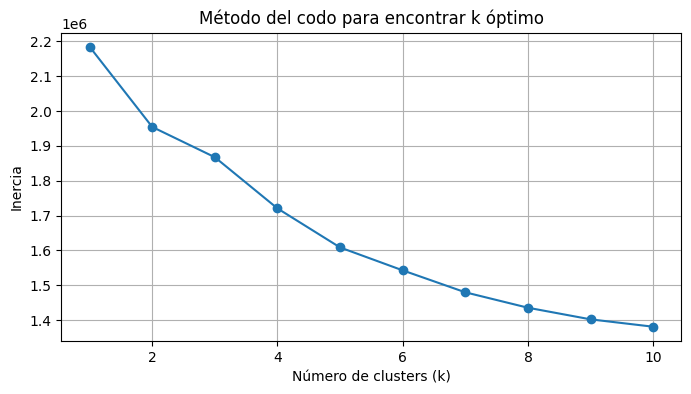

Etiquetas de clusters por ventana:
[1 2 2 ... 0 2 2]


In [32]:
# --- Convertir características en matriz 2D ---
filas = []
for ventana in caracteristicas:
    fila = []
    for joint, features in ventana.items():
        fila.extend(features.values())  # Agrega todas las características numéricas
    filas.append(fila)

X = np.array(filas)

# --- Normalización ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Elegir número óptimo de clusters (método del codo) ---
inercia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inercia.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8, 4))
plt.plot(k_range, inercia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para encontrar k óptimo')
plt.grid(True)
plt.show()

# --- Aplicar KMeans con k óptimo (por ejemplo, 3) ---
k_optimo = 3  # Cambia este valor según el codo
kmeans_final = KMeans(n_clusters=k_optimo, random_state=0)
labels = kmeans_final.fit_predict(X_scaled)

# labels contiene el número de cluster asignado a cada ventana
print("Etiquetas de clusters por ventana:")
print(labels)

# Interpretación de resultados

## Resumen estadístico

Este resumen estadístico es una herramienta poderosa para comprender las características que definen cada clúster y para validar la calidad del agrupamiento realizado. Si necesitas más detalles o visualizaciones, puedo ayudarte a implementarlos.



In [33]:
# Convertimos X_scaled nuevamente a DataFrame con nombres de columnas
n_features = len(filas[0])
columnas = []

for joint in caracteristicas[0].keys():
    for feature in caracteristicas[0][joint].keys():
        columnas.append(f'{joint}_{feature}')

df_clusters = pd.DataFrame(X_scaled, columns=columnas)
df_clusters['cluster'] = labels

# Obtener estadísticas por grupo
resumen = df_clusters.groupby('cluster').agg(['mean', 'std'])
print("Resumen estadístico por cluster:")
print(resumen)


Resumen estadístico por cluster:
        pelvis_x_media           pelvis_x_desviacion            \
                  mean       std                mean       std   
cluster                                                          
0            -0.061278  0.877583           -0.368649  0.799965   
1             0.022268  0.997033           -0.084831  1.136353   
2            -0.011296  1.053810            0.306574  0.703690   

        pelvis_x_minimo           pelvis_x_maximo           pelvis_x_energia  \
                   mean       std            mean       std             mean   
cluster                                                                        
0             -0.023242  0.877690       -0.107099  0.875820        -0.132127   
1              0.040543  0.998970        0.005840  0.994243        -0.007336   
2             -0.059229  1.048748        0.036882  1.057146         0.070392   

                   ... vel_z_maximo           vel_z_energia            \
              st

Resumen Estadístico por Clúster:

El resumen estadístico muestra las características promedio y la variabilidad (desviación estándar) de cada clúster para todas las articulaciones y características calculadas.
Por ejemplo, en el clúster 0, la media de pelvis_x_media es -0.061278, lo que indica que los valores promedio de la coordenada X de la pelvis están ligeramente desplazados hacia valores negativos, mientras que la desviación estándar es 0.877583, lo que sugiere una dispersión moderada en los datos.
Comparando los clústeres, se pueden identificar diferencias clave. Por ejemplo, el clúster 2 tiene un valor promedio más alto en pelvis_x_maximo (0.036882), lo que podría indicar que los movimientos en este grupo tienden a alcanzar posiciones más extremas en la dirección X.

Diferencias entre Clústeres:

Los valores de energía y complejidad en las características de velocidad (vel_z_energia, vel_z_complejidad) pueden ser indicadores de patrones de movimiento más dinámicos o controlados.
Por ejemplo, el clúster 0 tiene un valor promedio más alto en vel_z_energia (0.025037), lo que podría representar movimientos más intensos en la dirección Z, mientras que el clúster 2 tiene un valor negativo en vel_z_energia (-0.019294), lo que podría indicar movimientos más suaves o menos energéticos.

Patrones de Movimiento:

Los valores de mínimo y máximo en las características de posición (pelvis_x_minimo, pelvis_x_maximo) ayudan a identificar los rangos de movimiento en cada clúster.
Por ejemplo, el clúster 1 tiene un valor promedio más alto en pelvis_x_minimo (0.040543), lo que podría indicar que los movimientos en este grupo tienden a mantenerse en un rango más positivo en la dirección X.



## Boxplots de las características

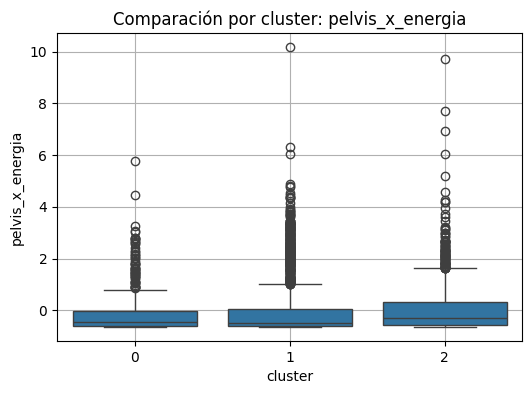

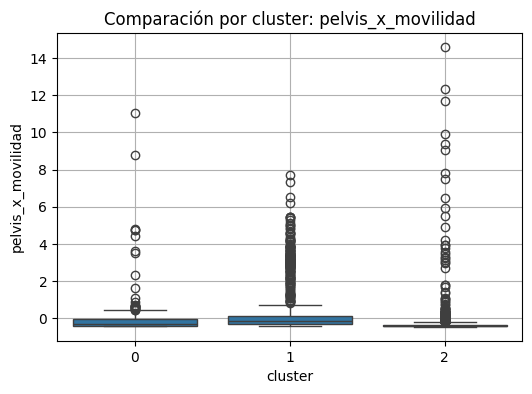

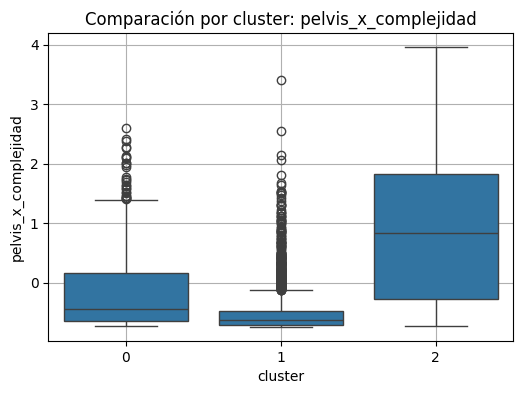

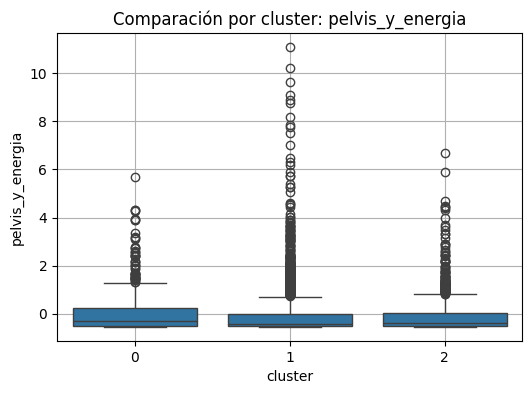

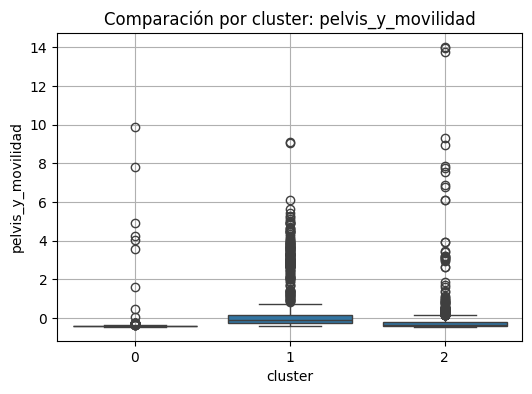

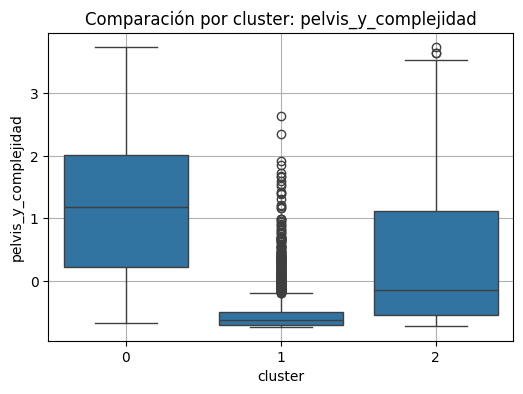

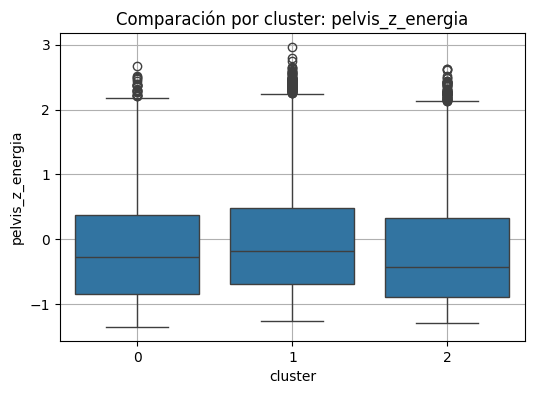

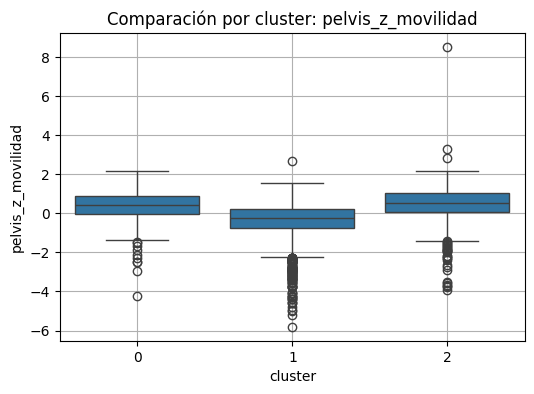

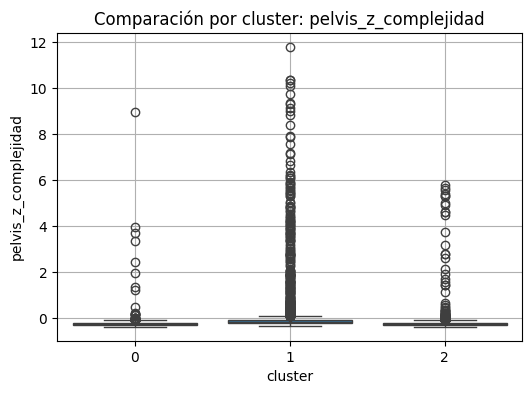

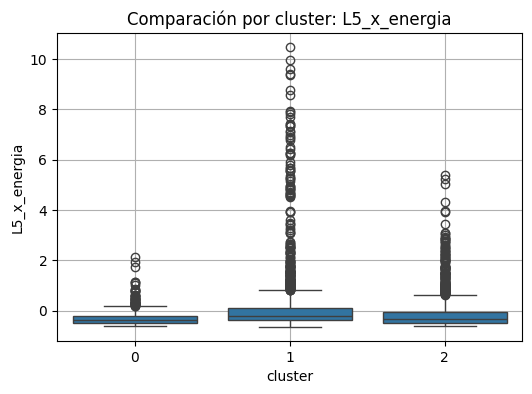

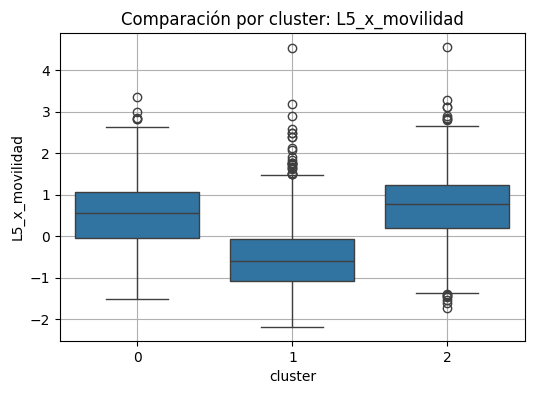

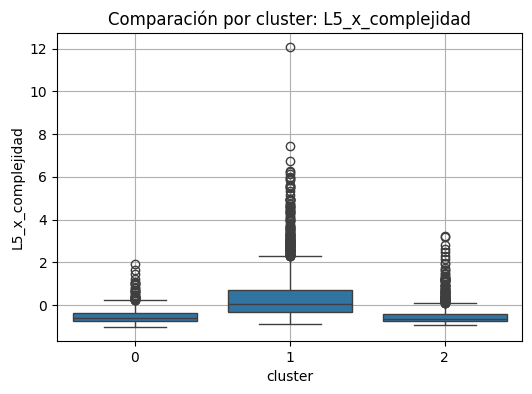

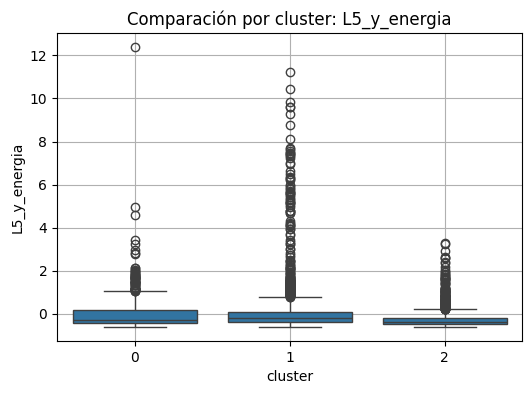

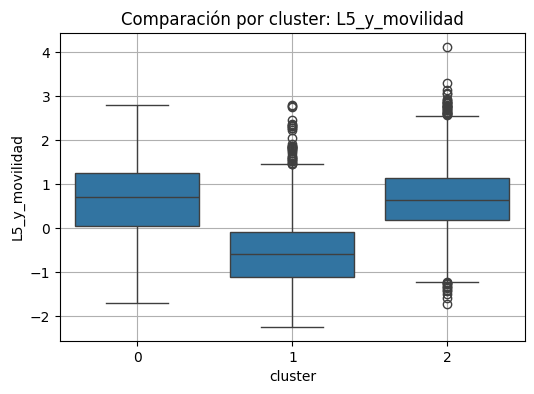

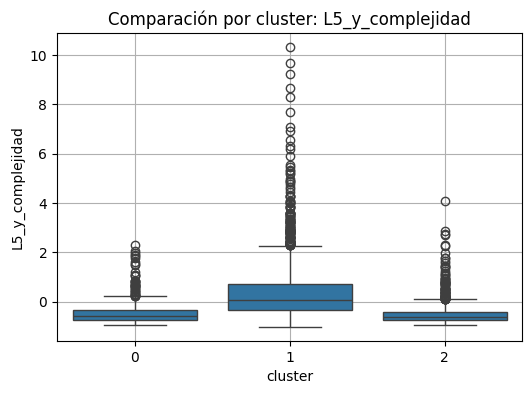

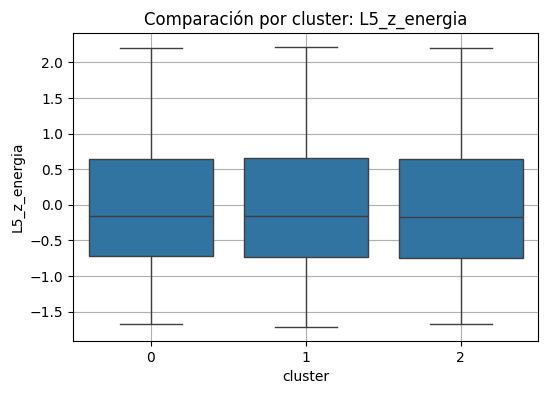

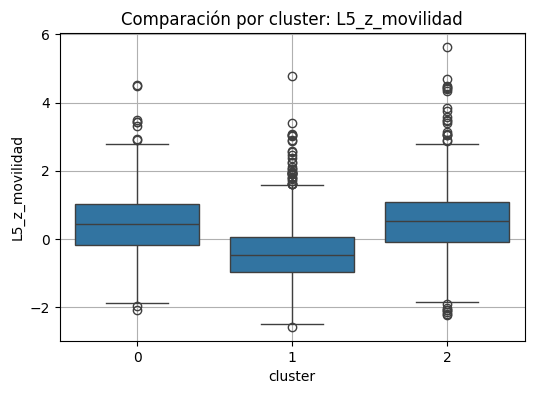

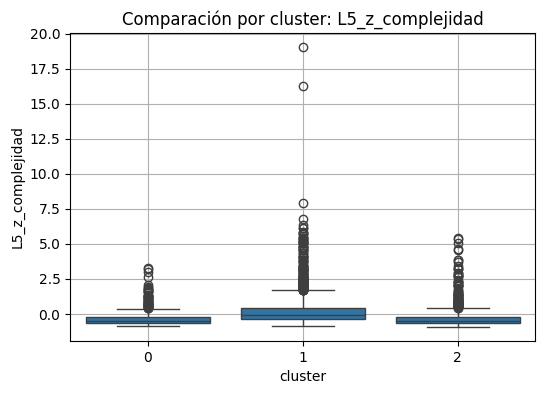

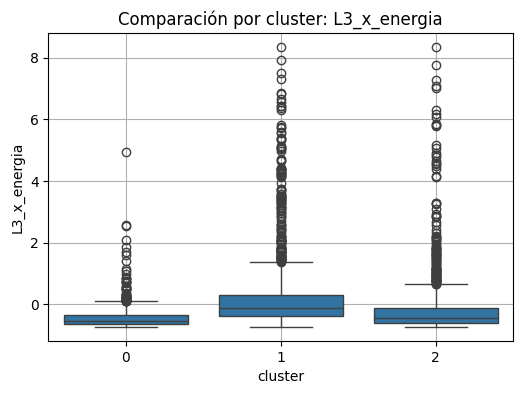

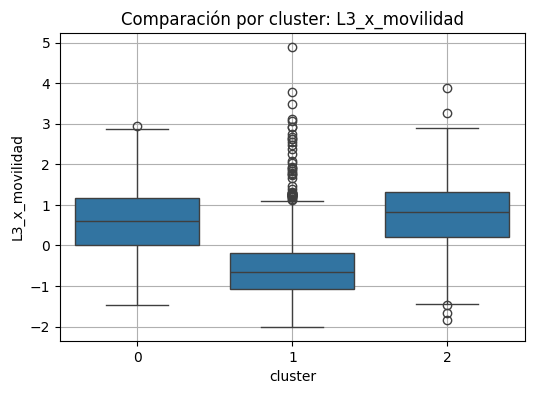

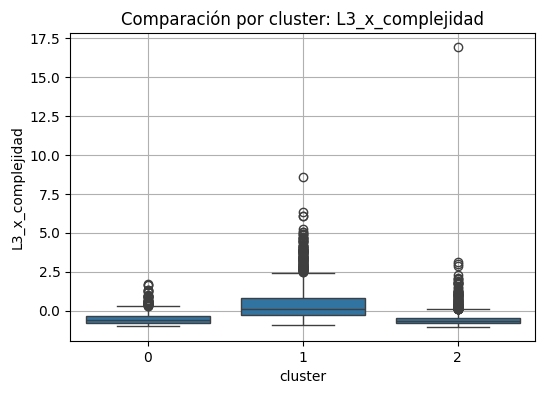

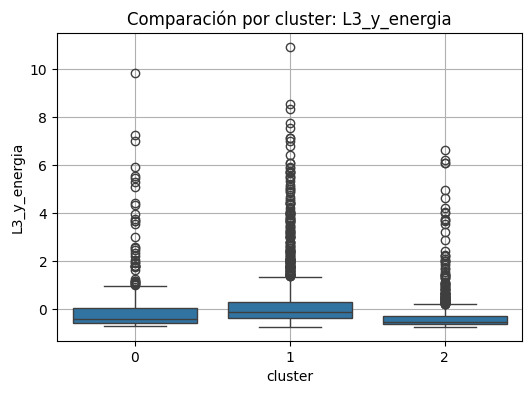

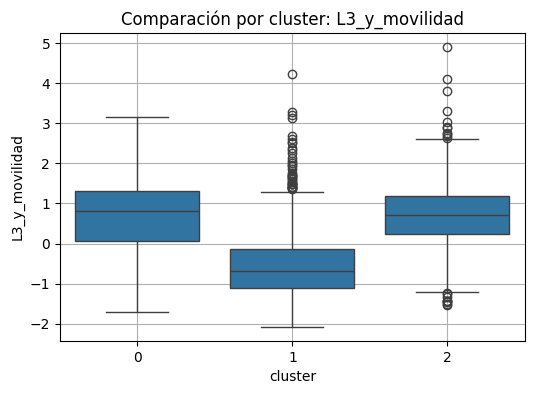

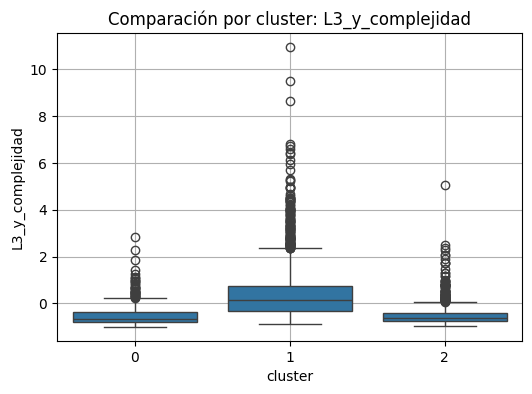

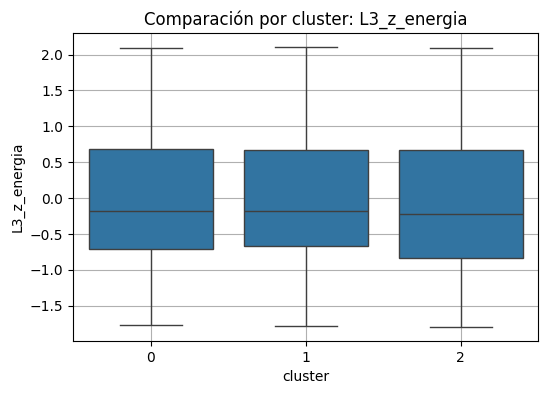

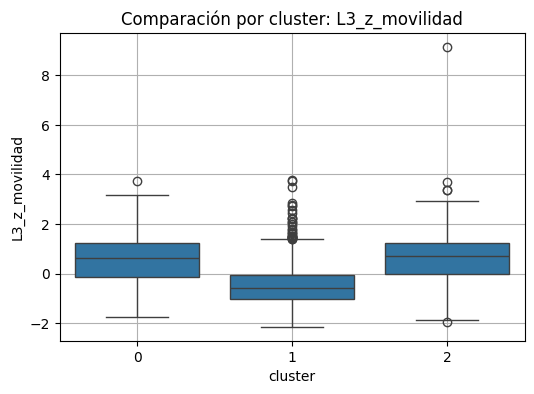

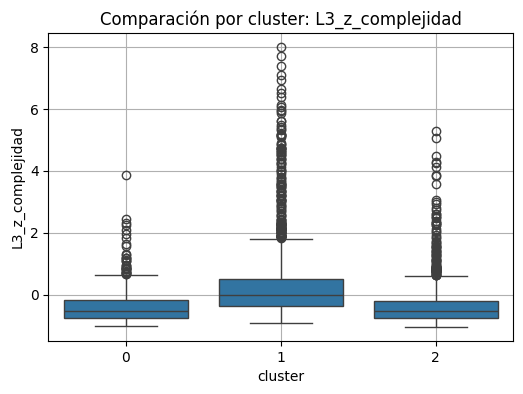

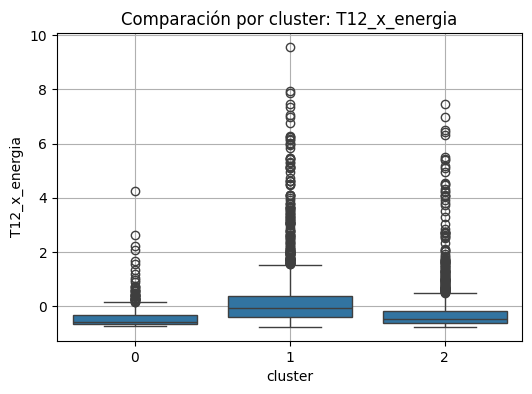

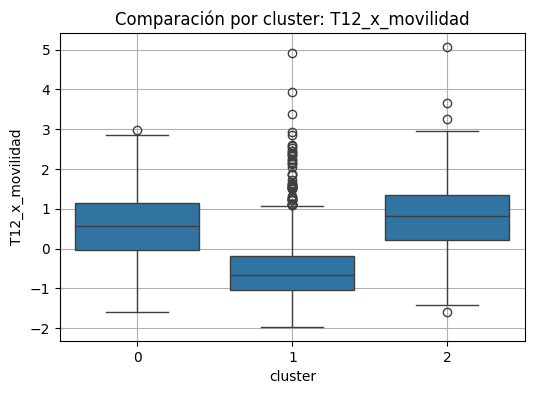

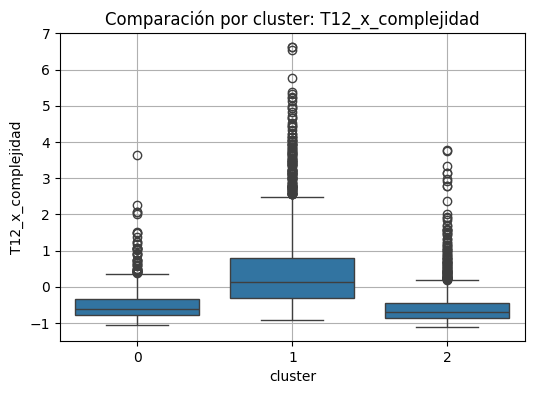

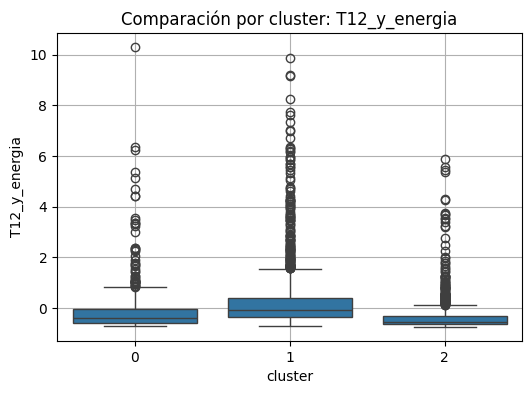

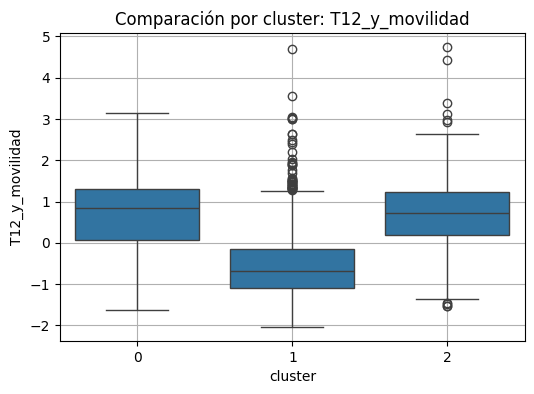

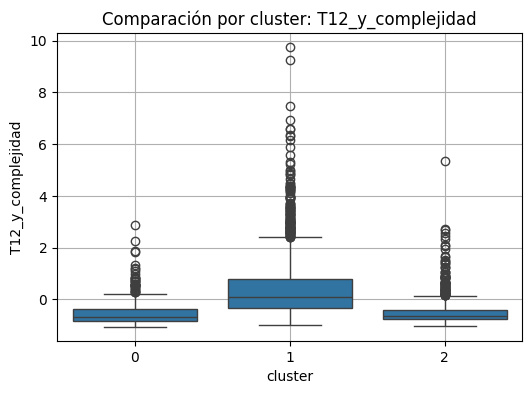

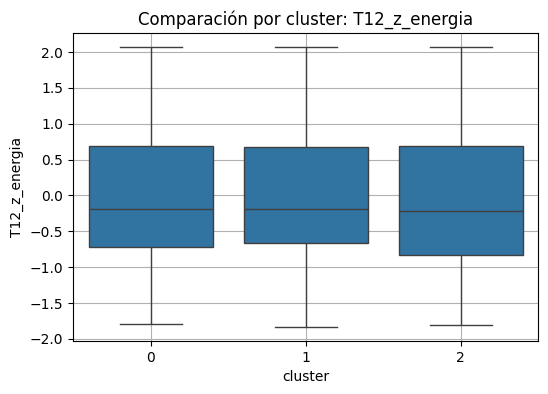

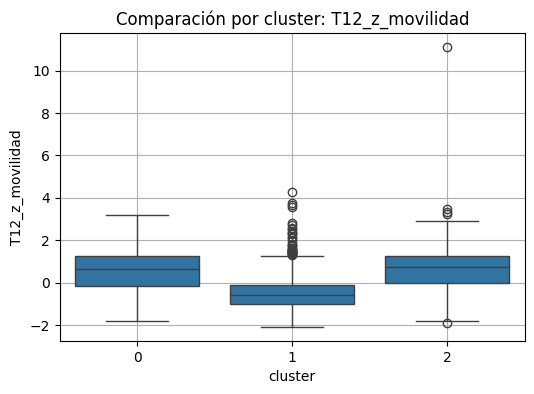

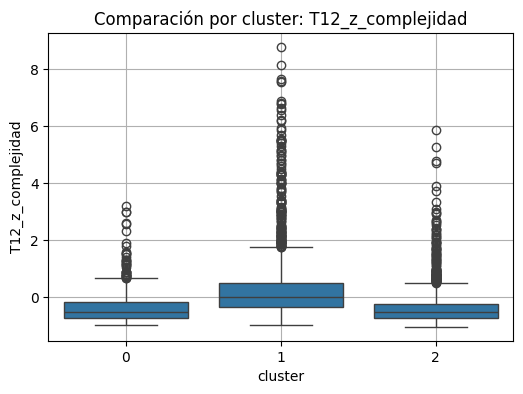

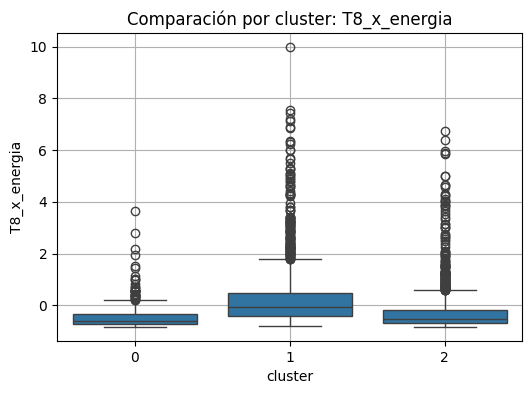

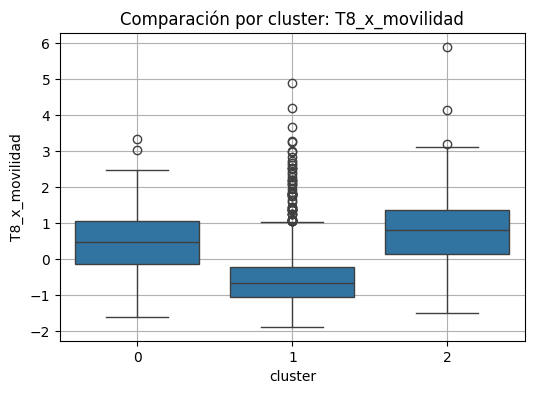

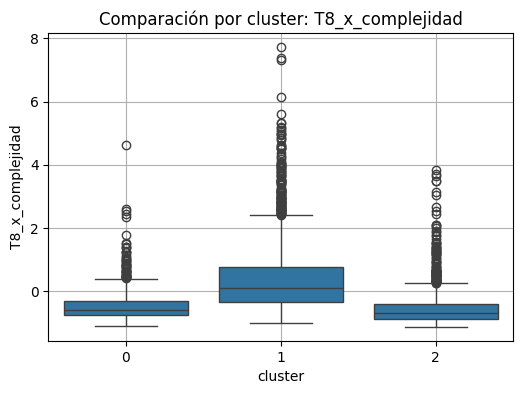

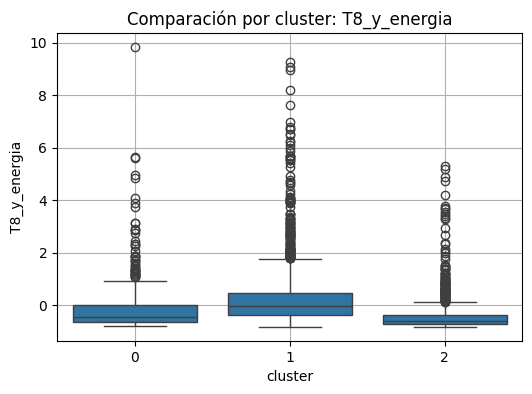

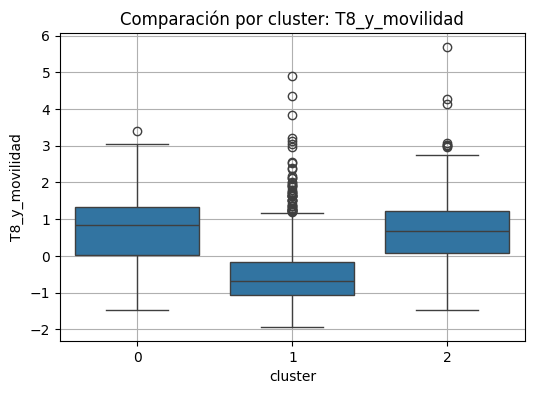

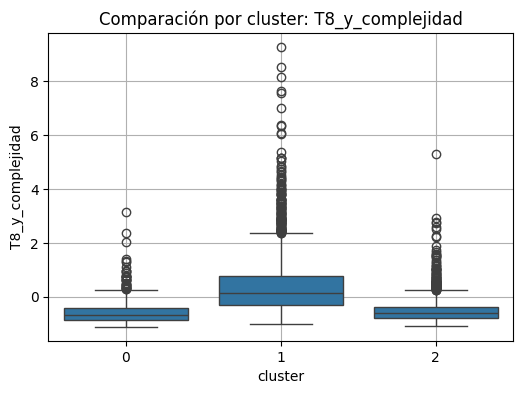

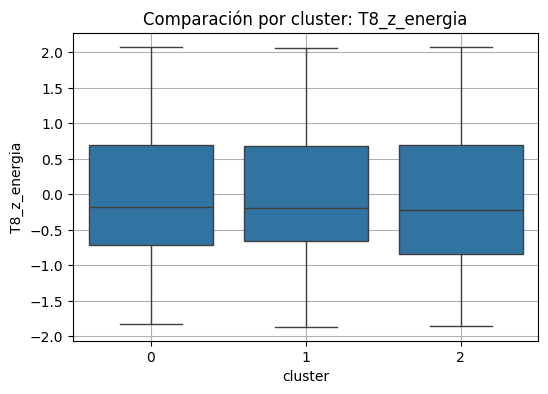

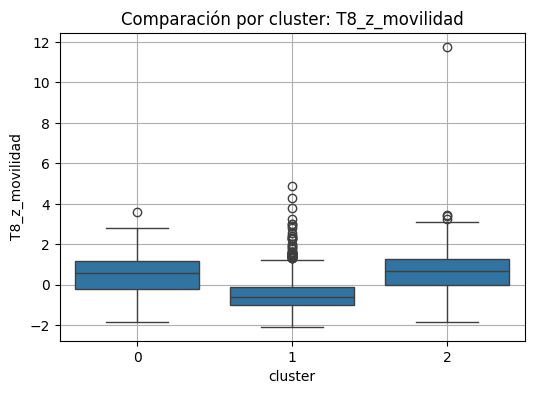

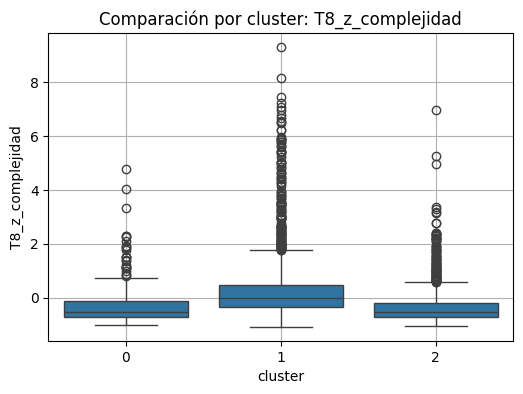

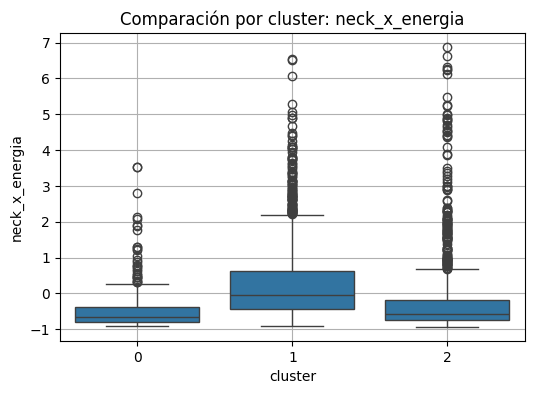

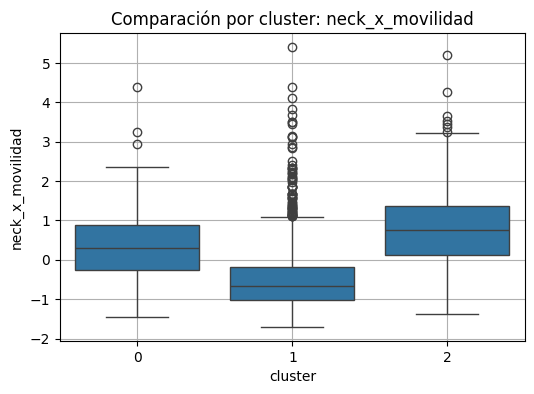

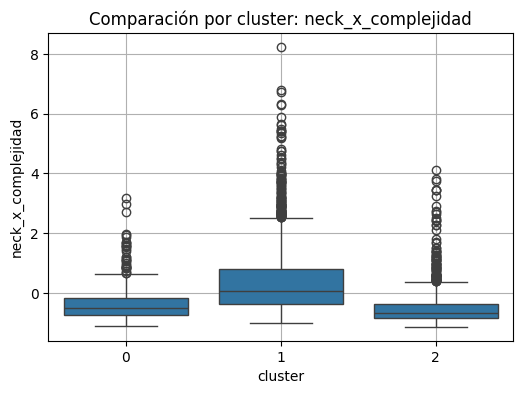

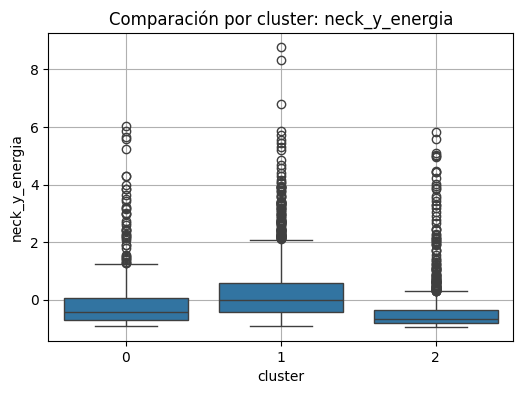

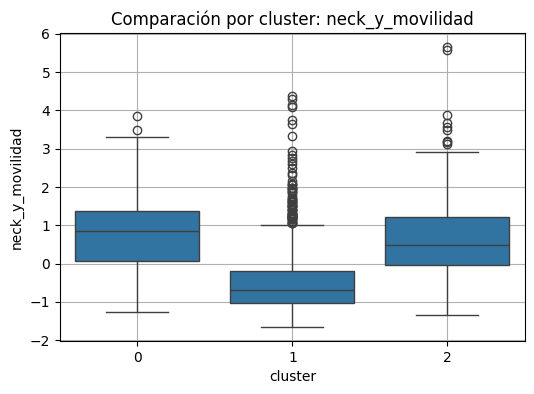

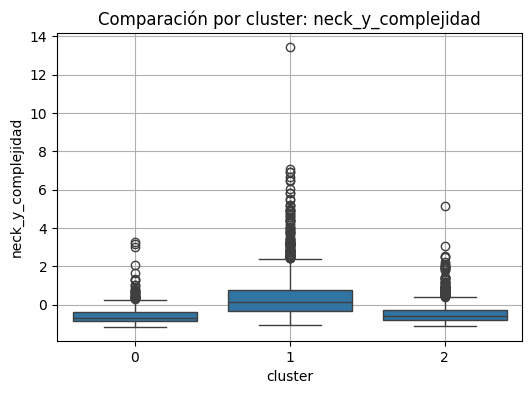

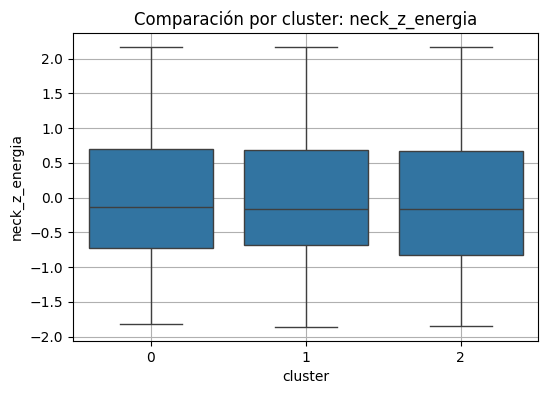

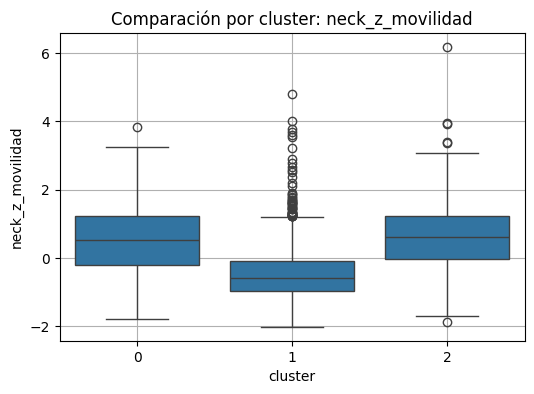

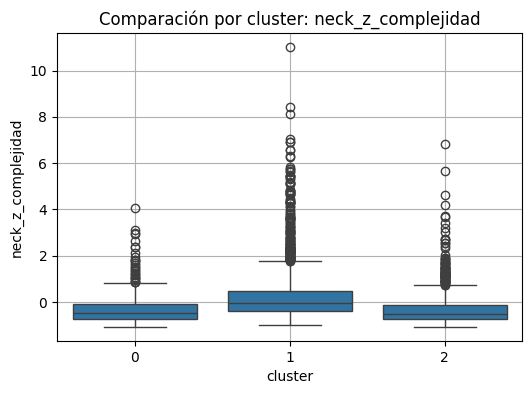

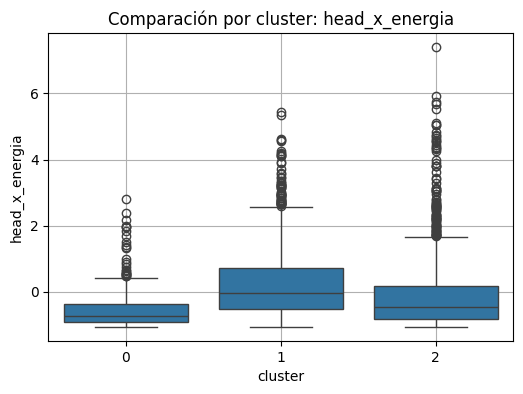

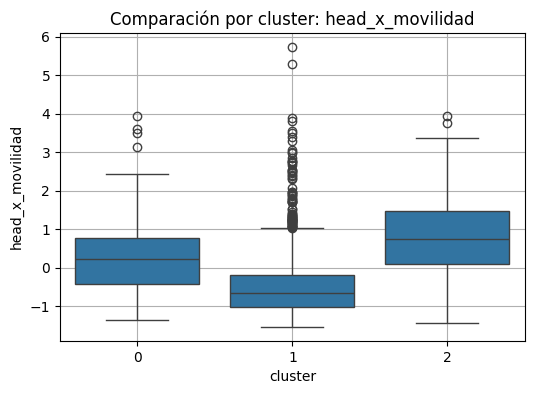

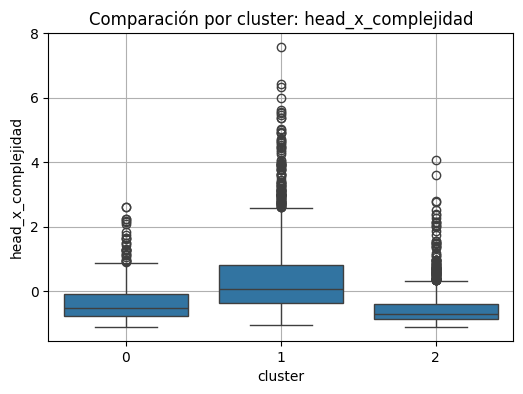

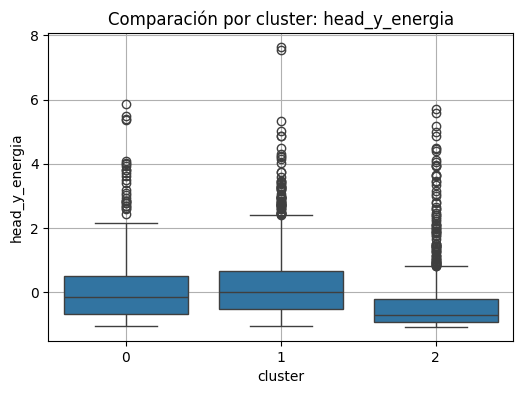

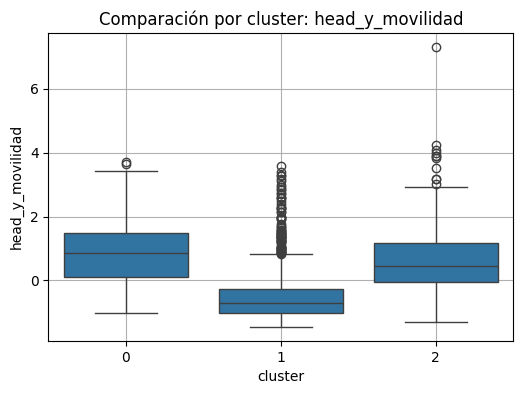

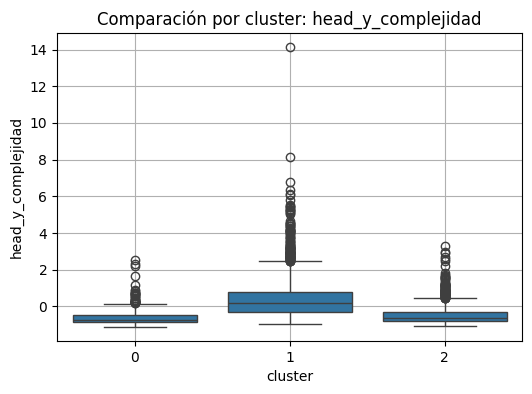

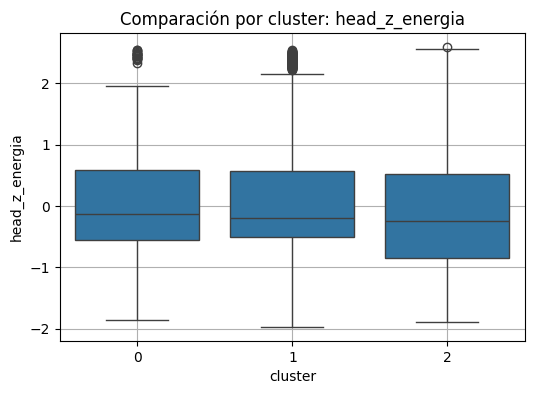

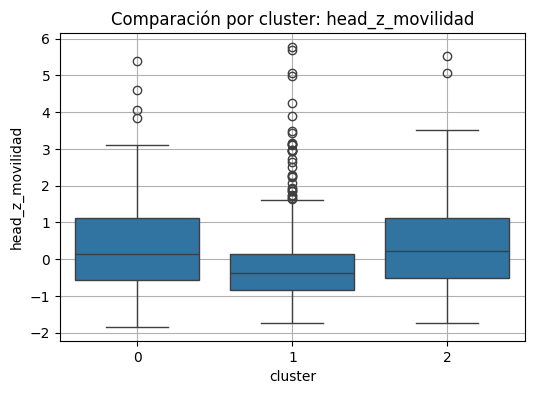

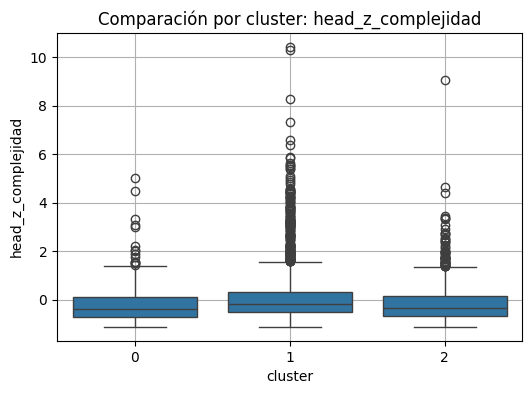

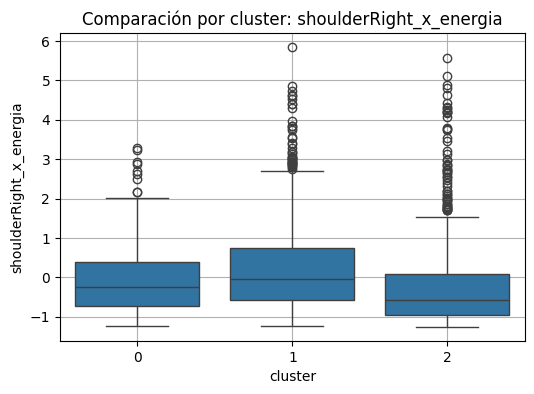

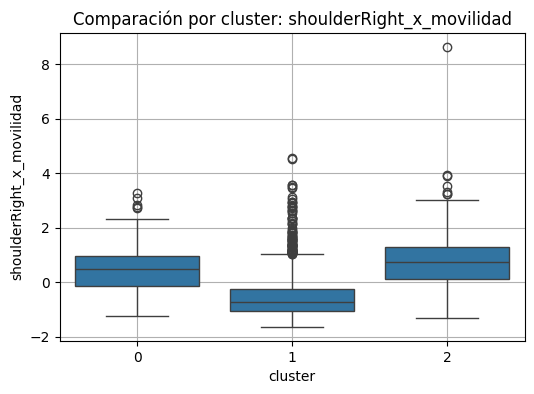

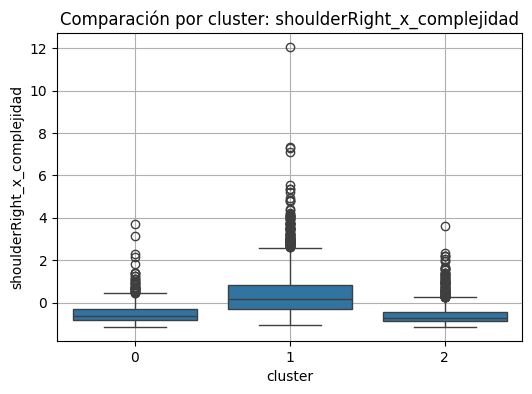

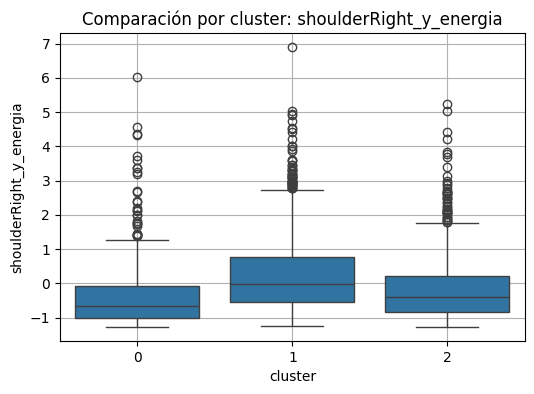

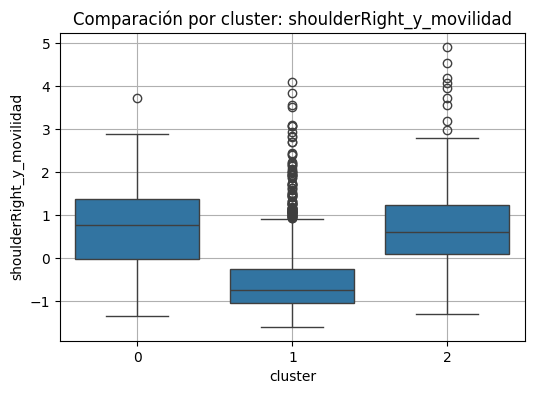

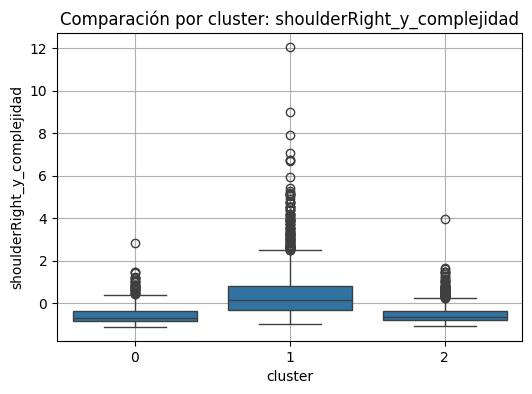

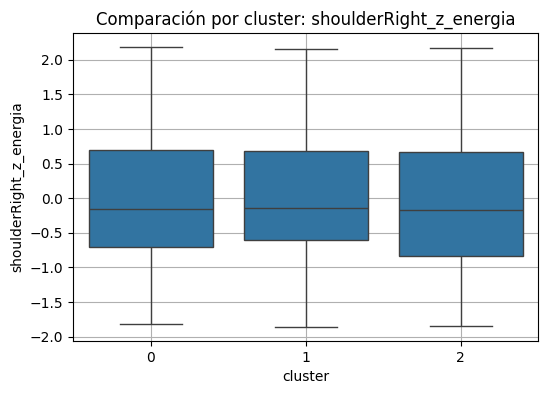

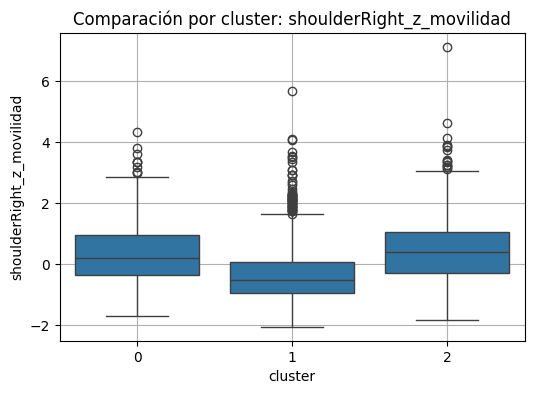

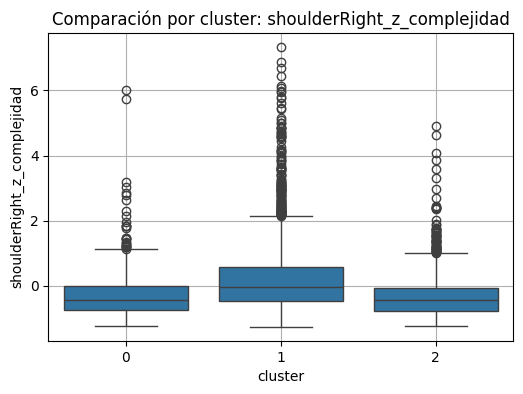

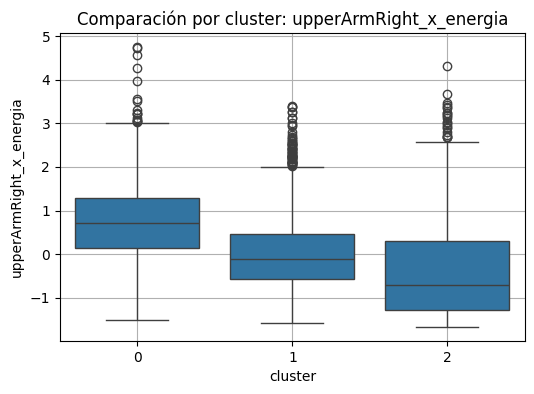

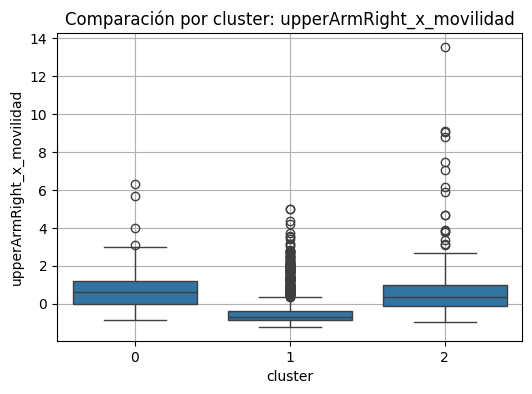

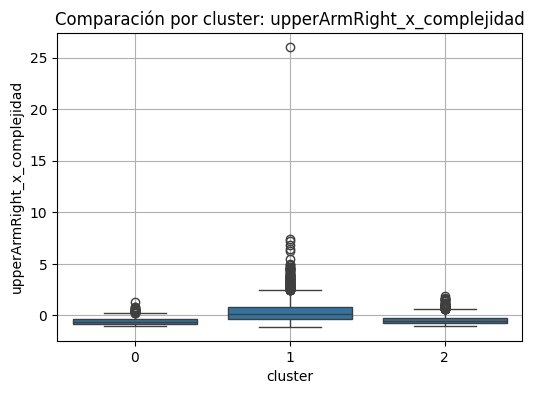

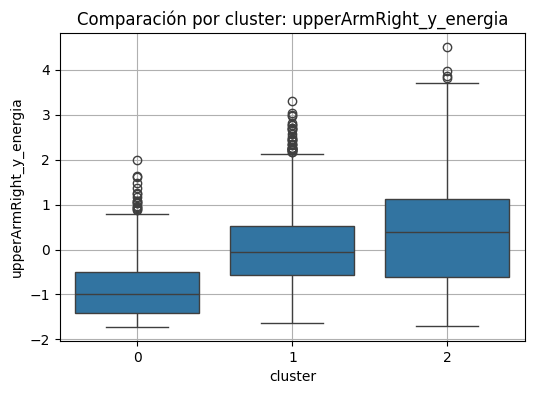

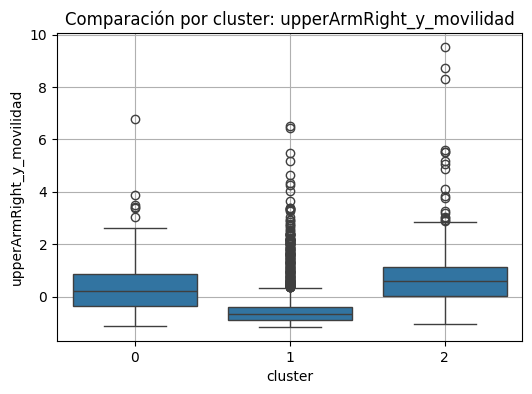

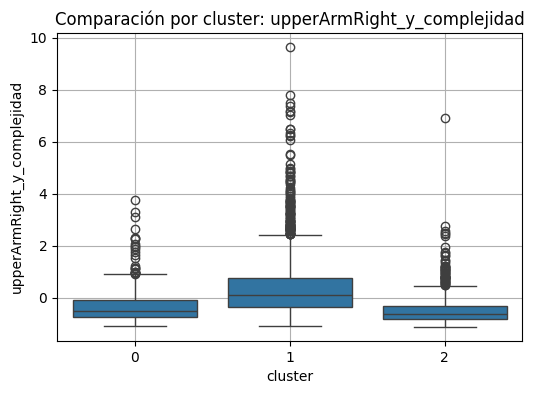

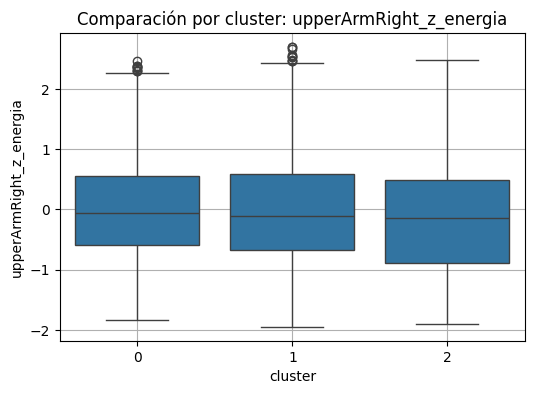

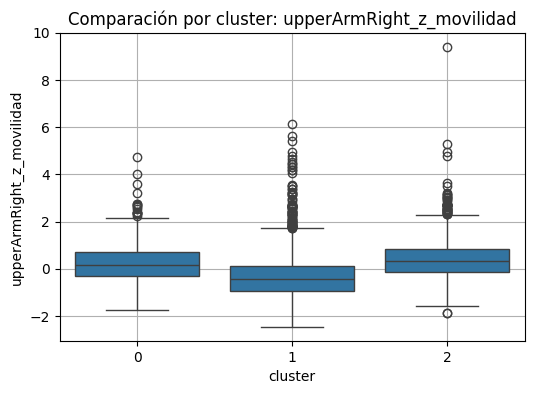

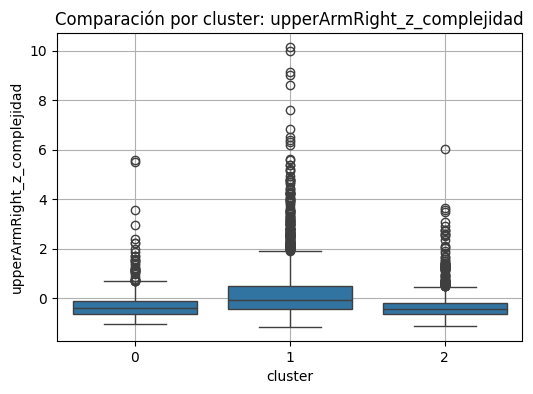

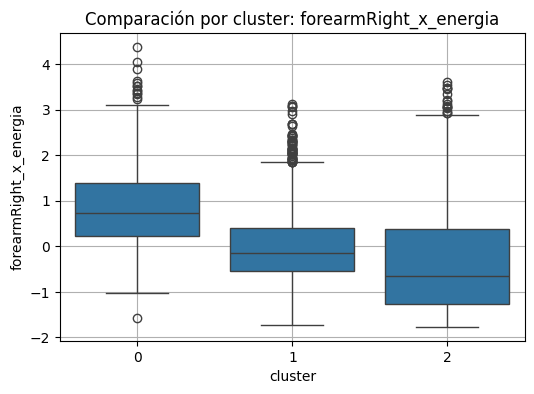

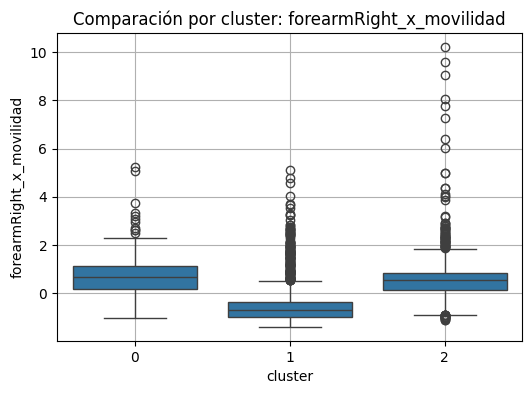

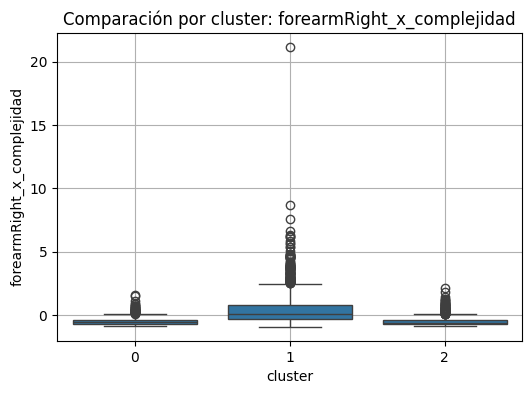

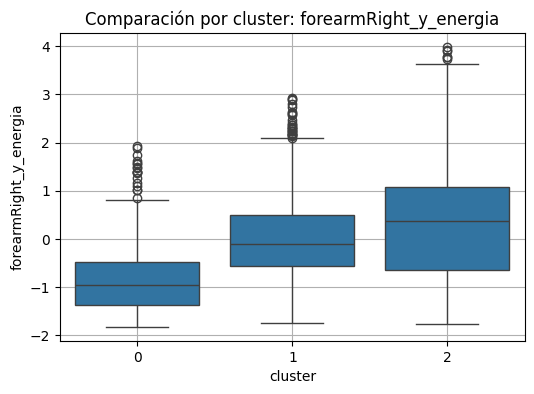

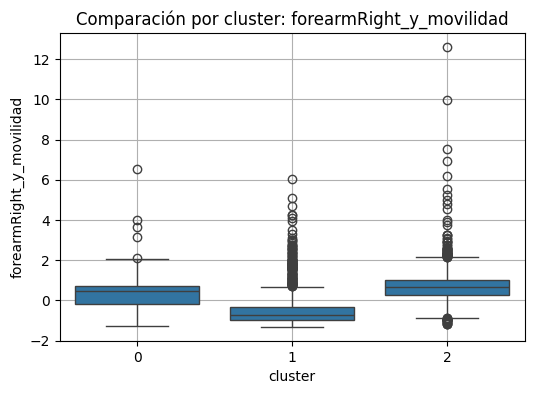

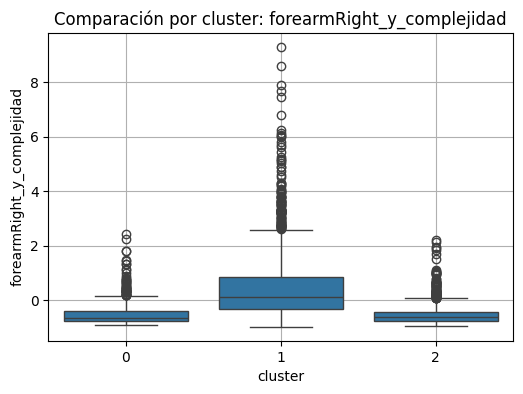

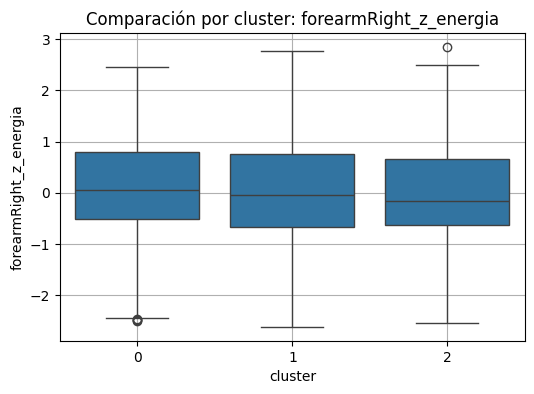

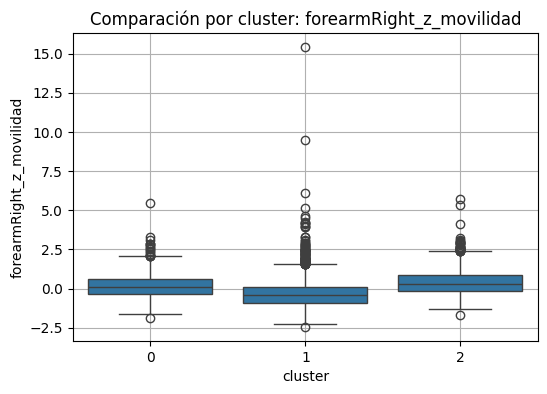

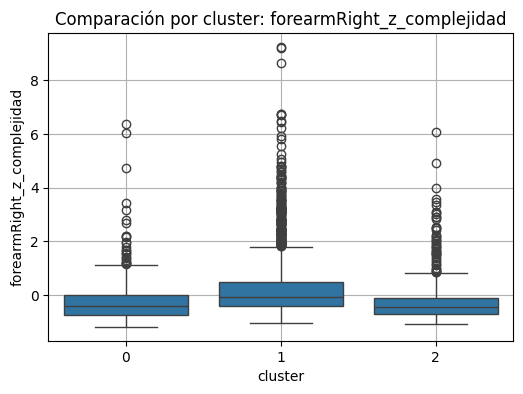

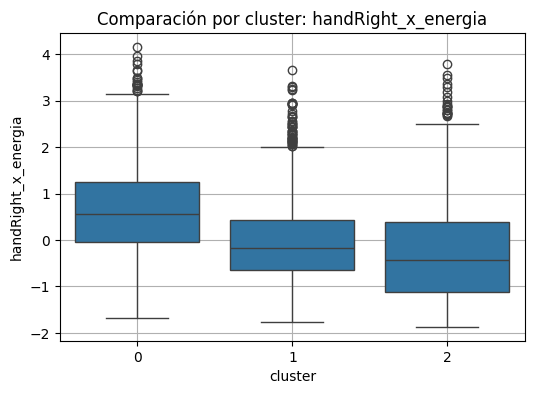

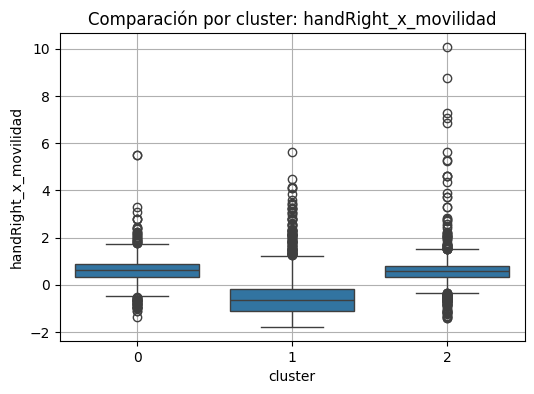

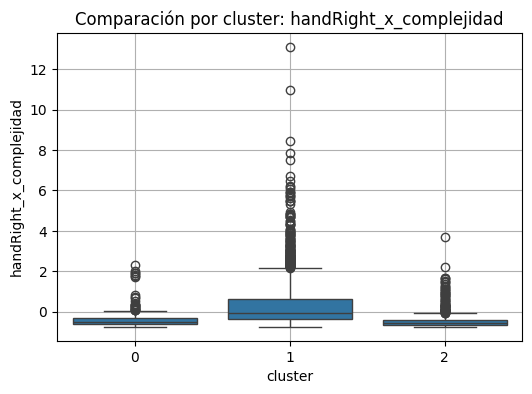

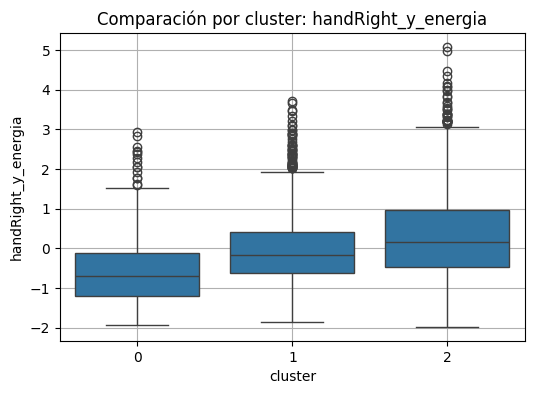

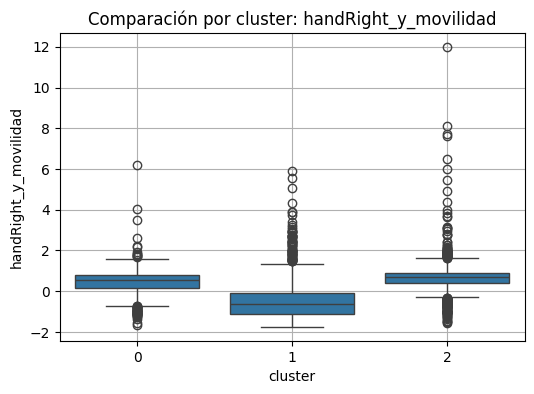

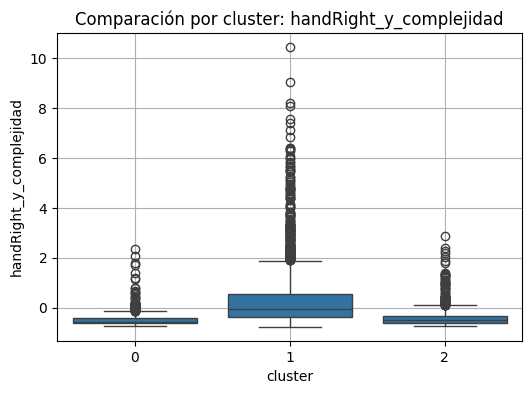

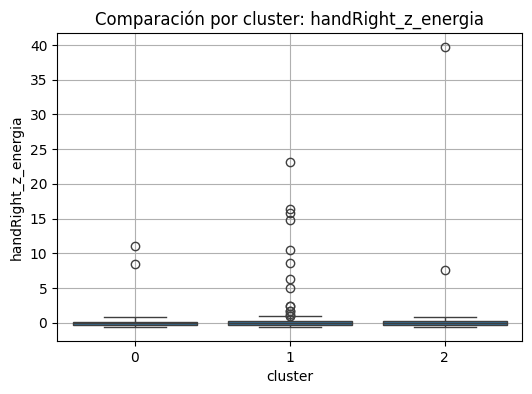

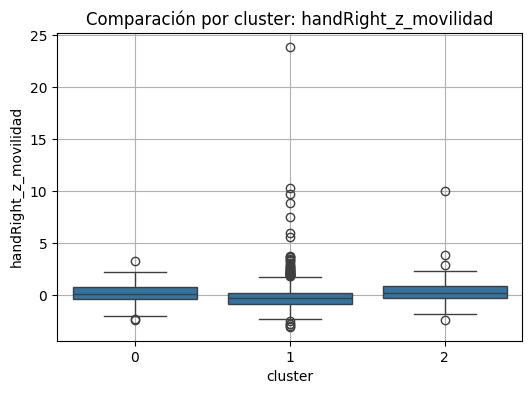

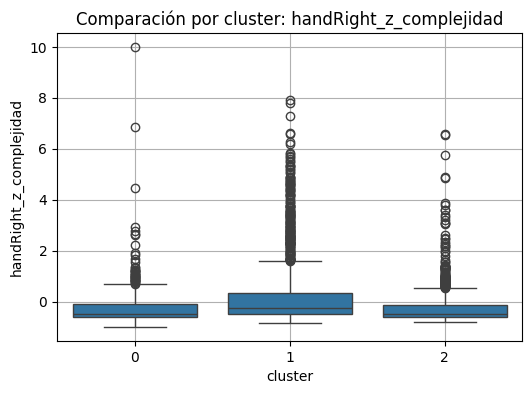

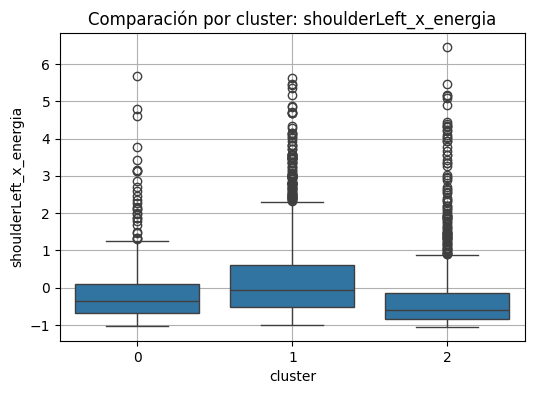

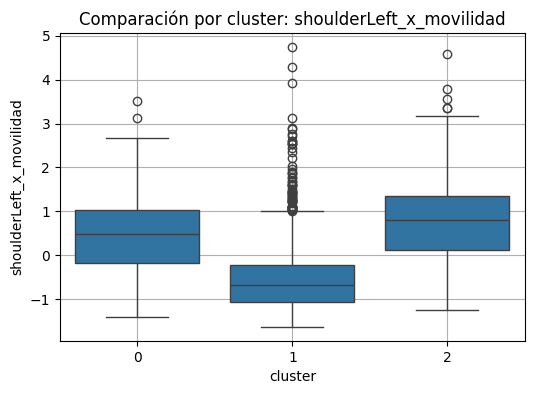

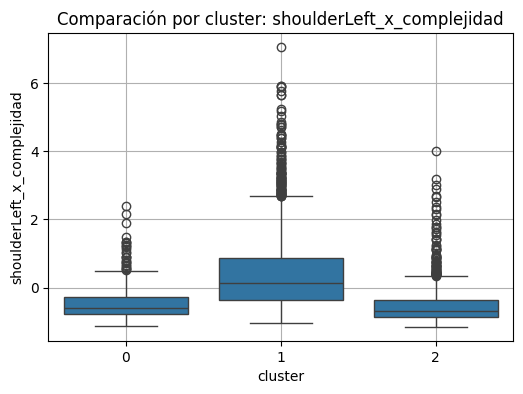

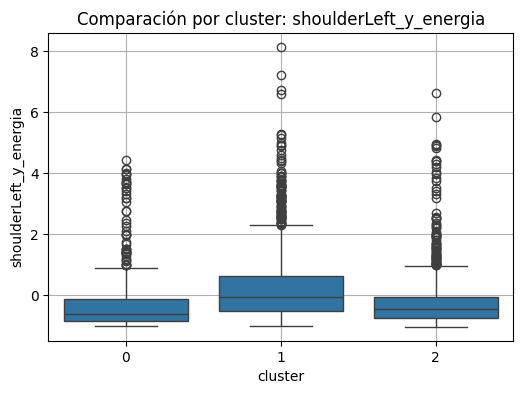

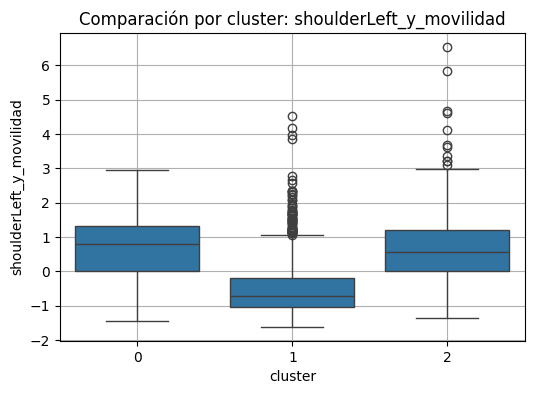

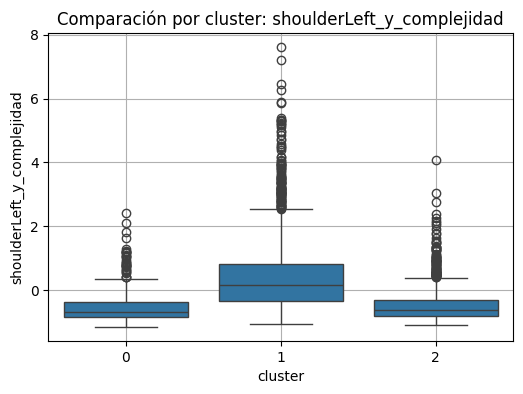

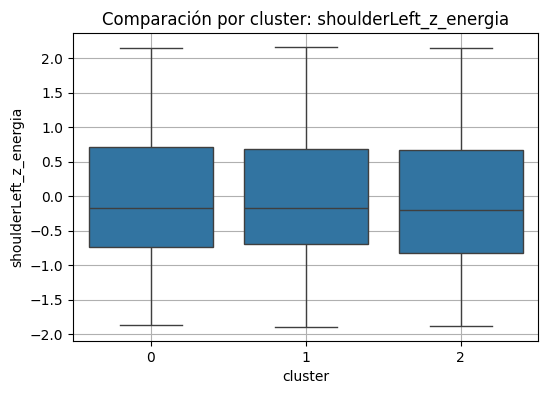

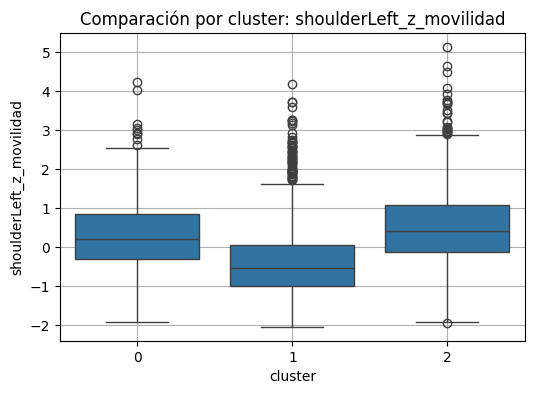

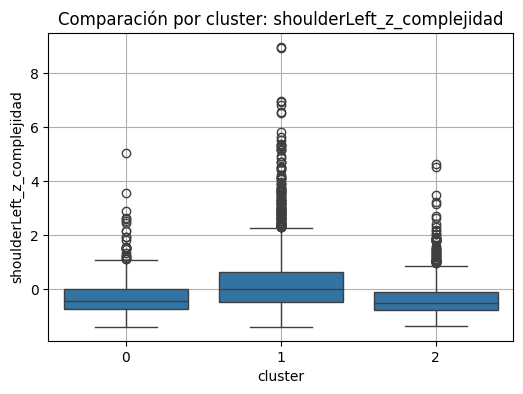

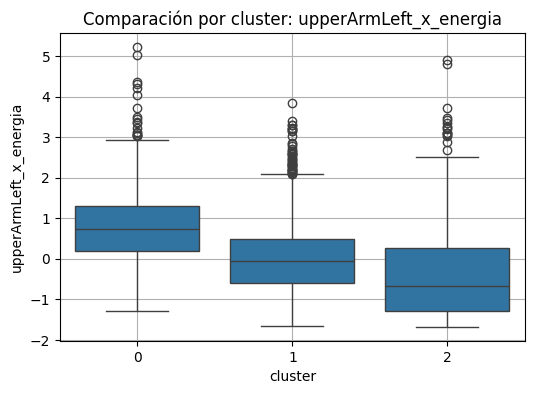

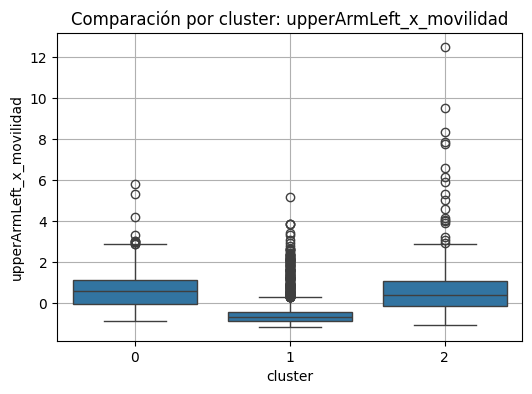

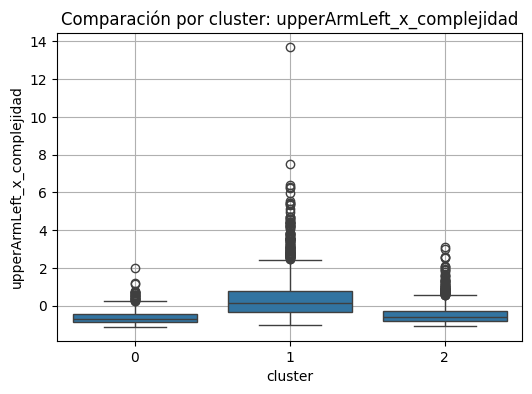

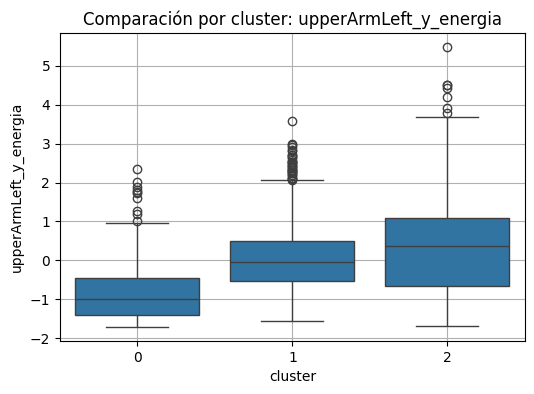

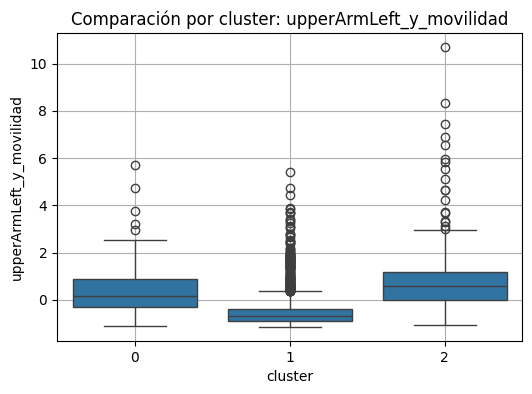

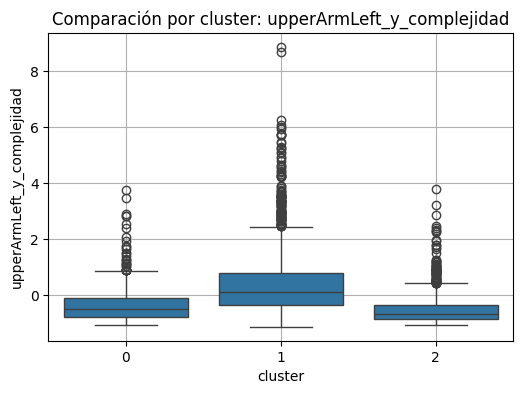

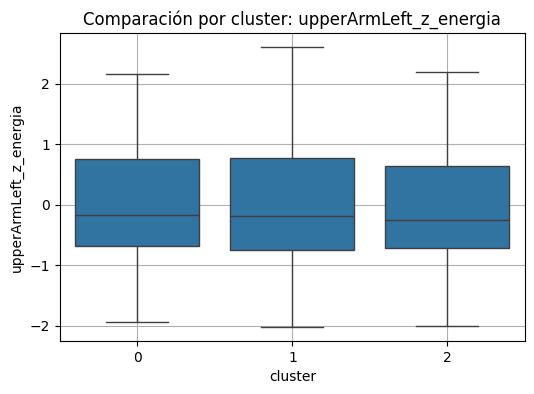

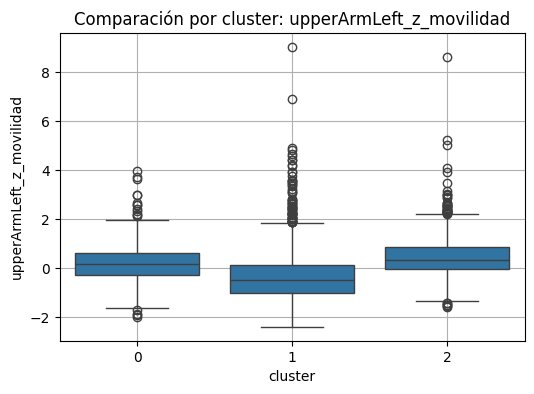

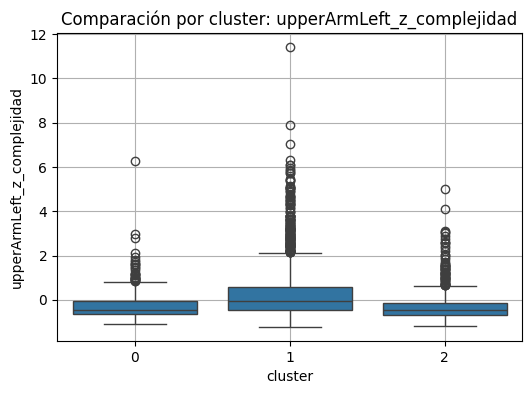

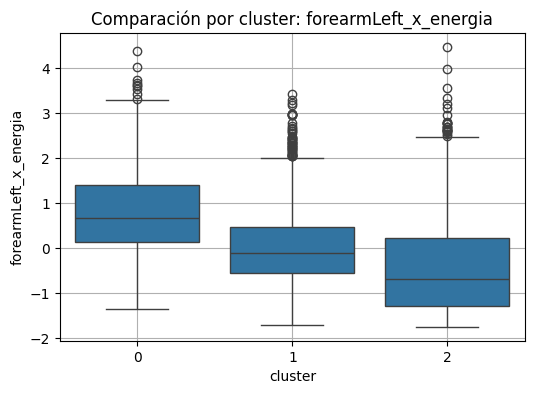

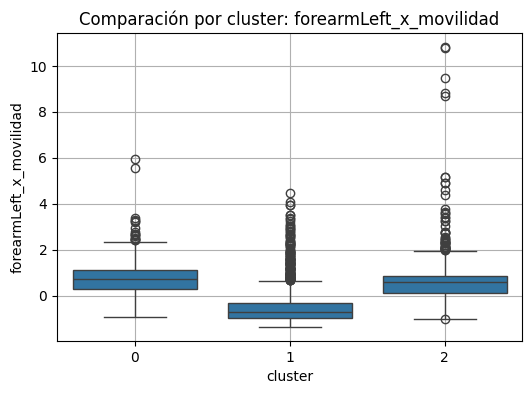

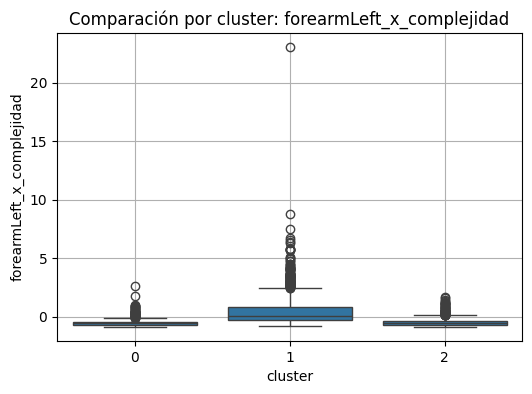

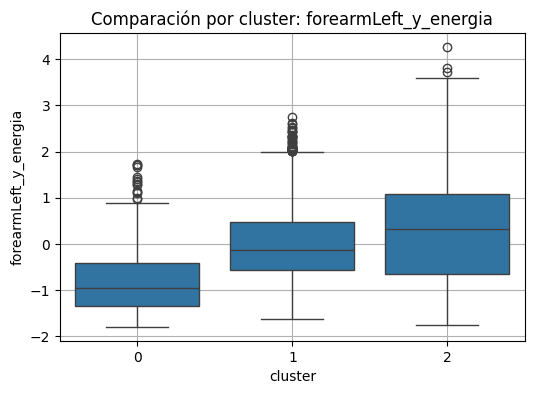

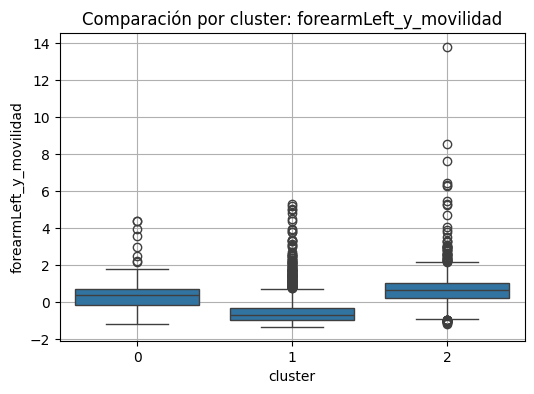

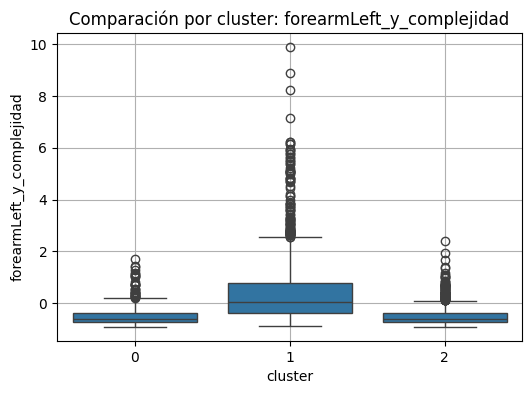

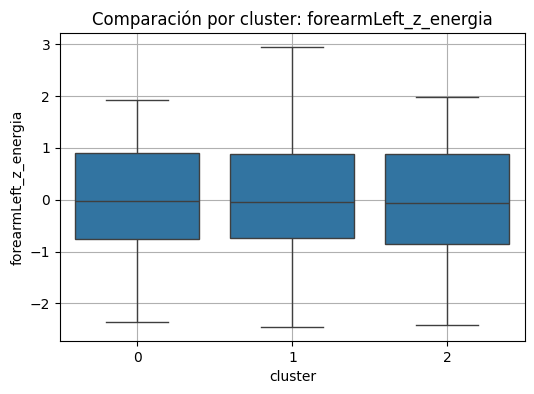

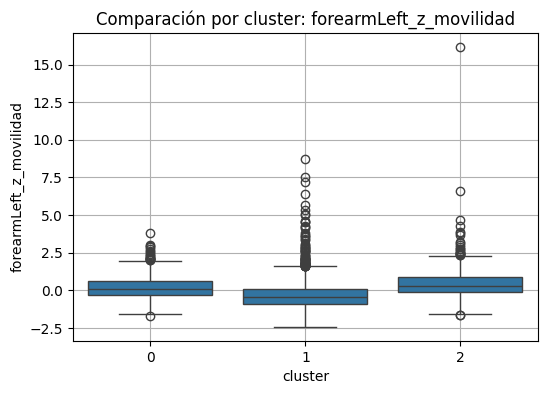

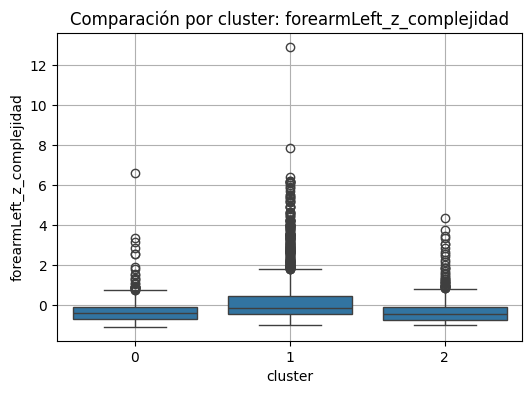

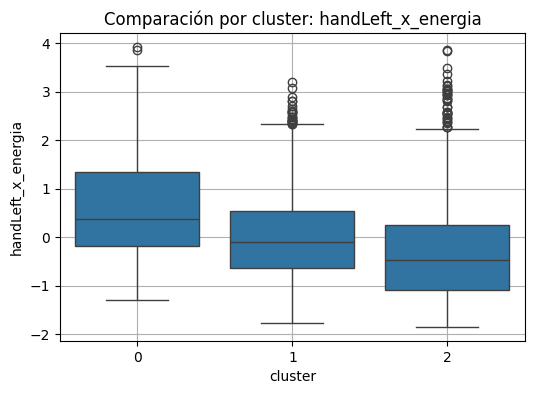

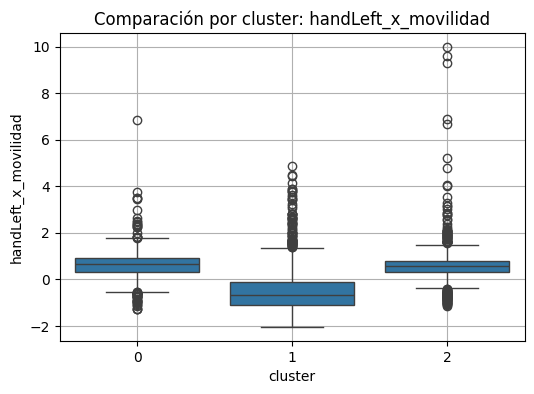

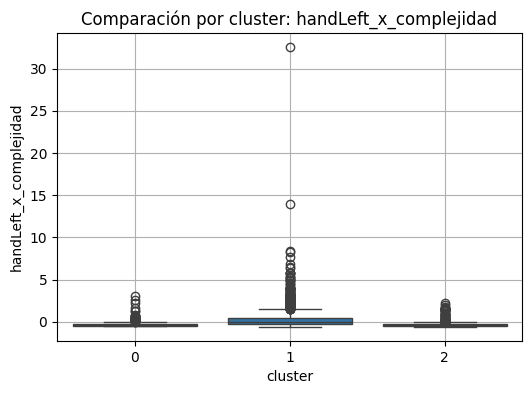

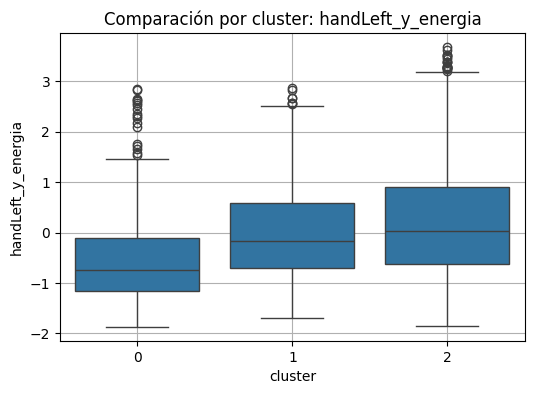

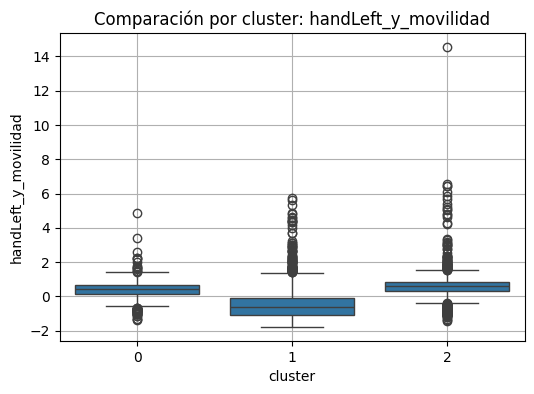

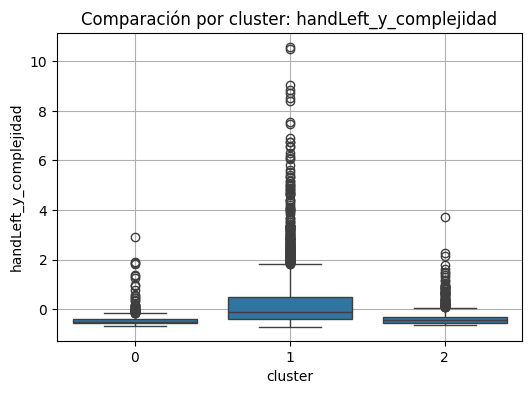

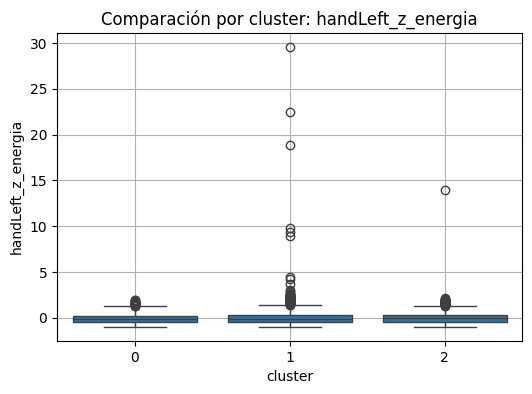

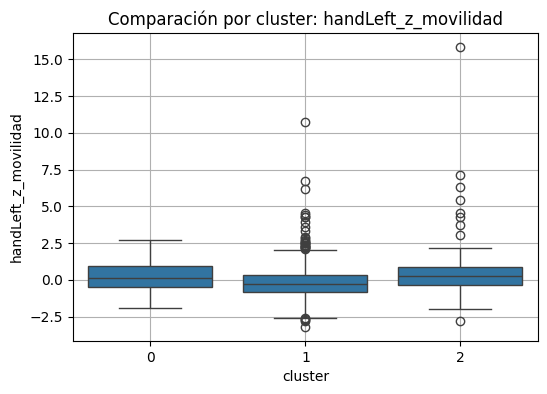

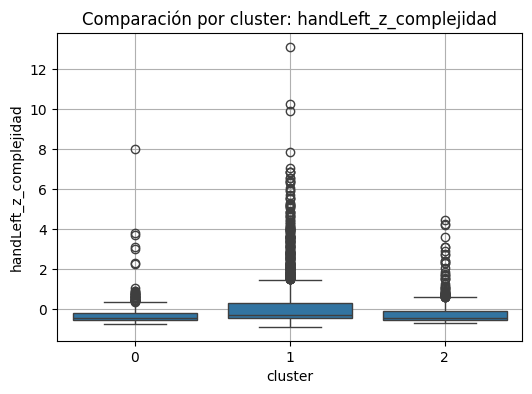

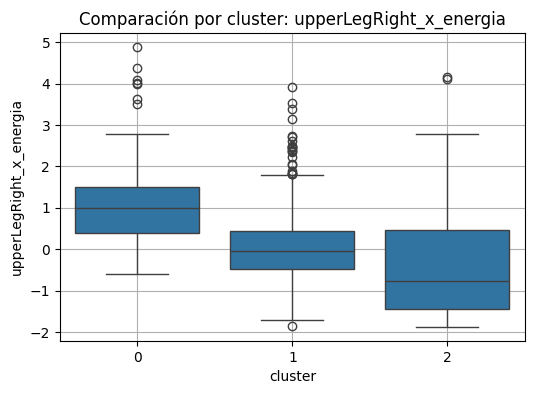

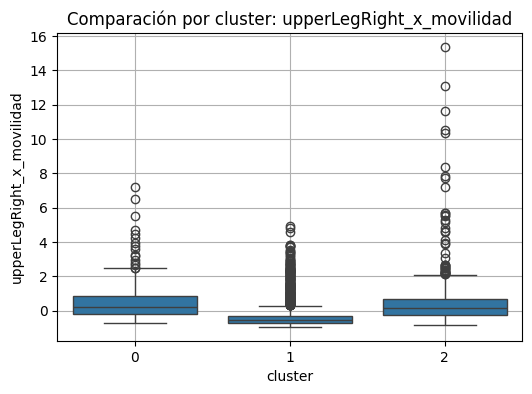

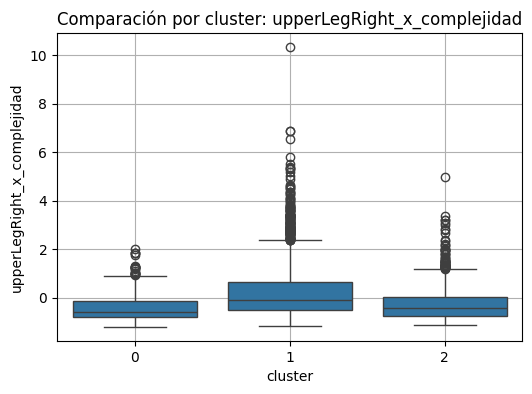

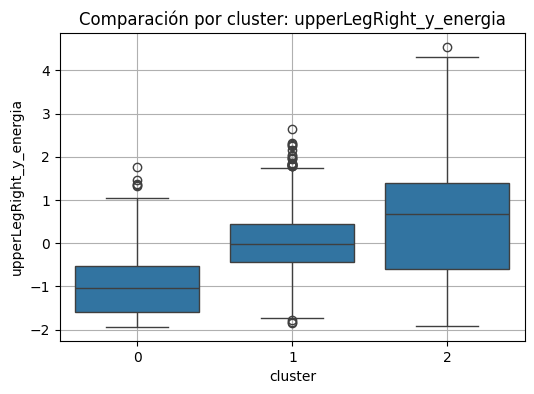

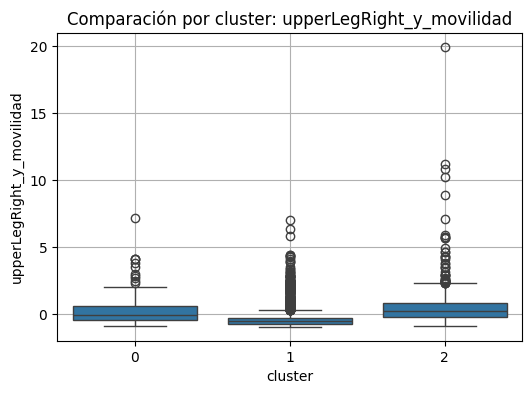

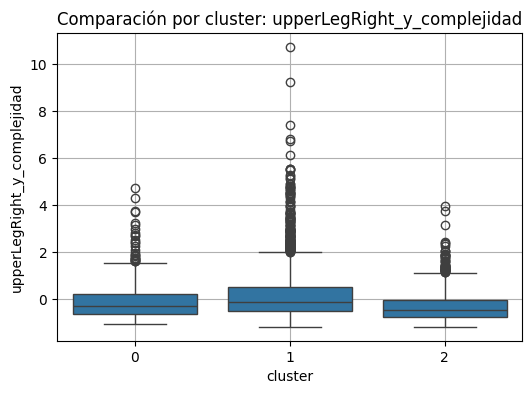

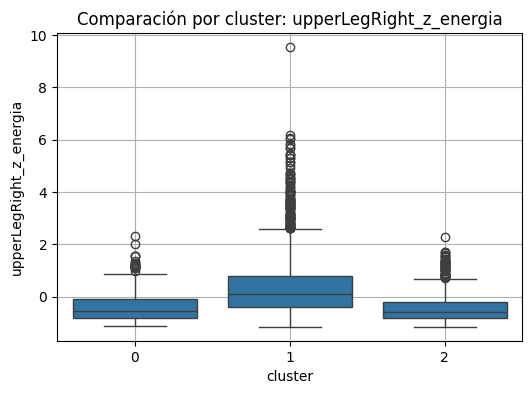

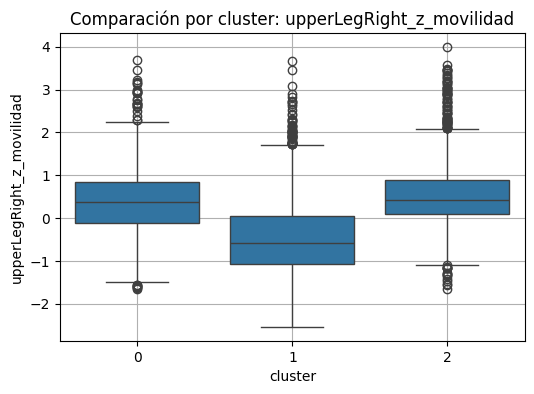

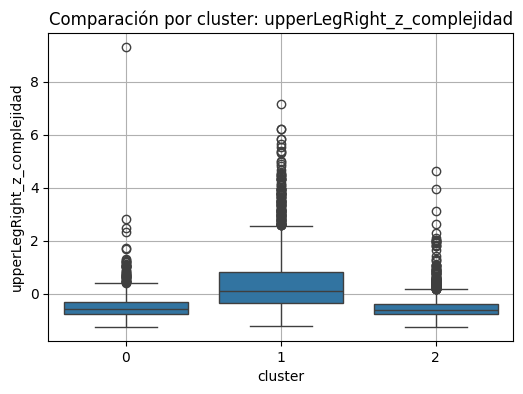

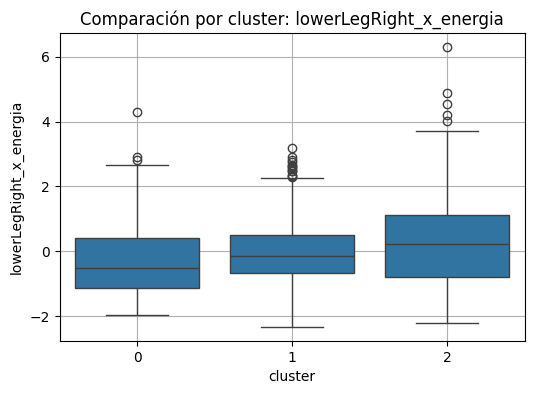

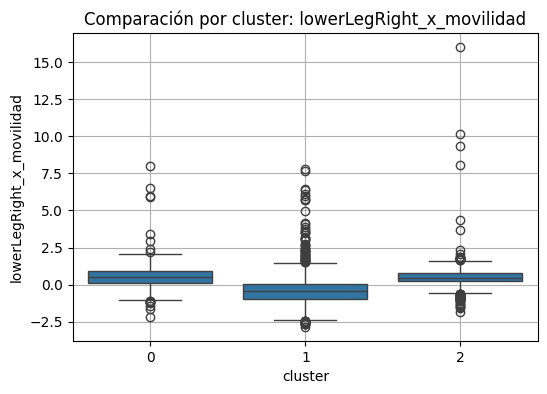

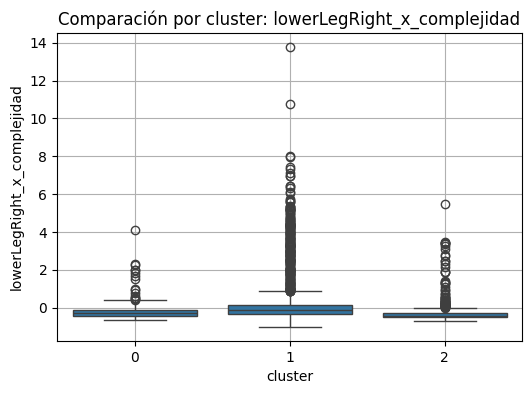

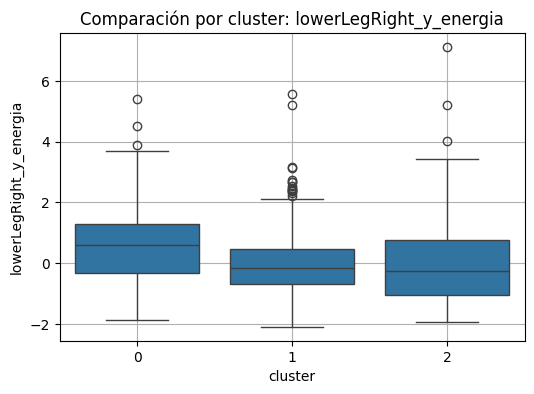

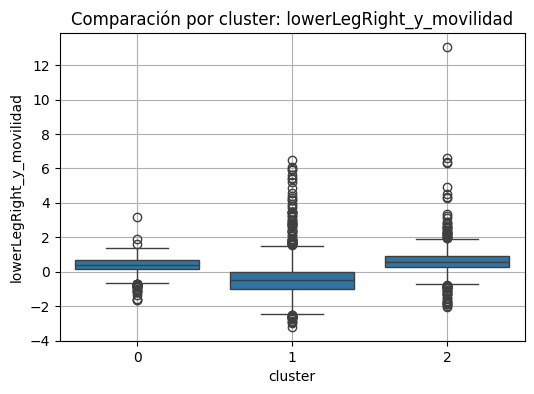

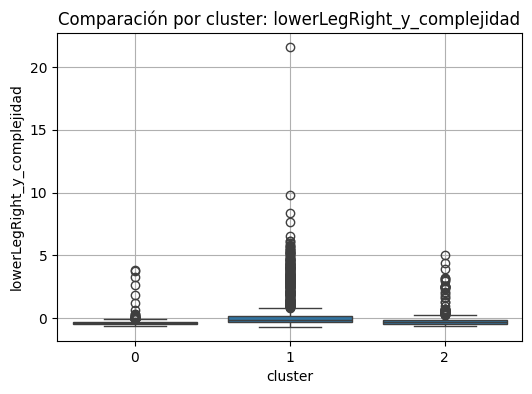

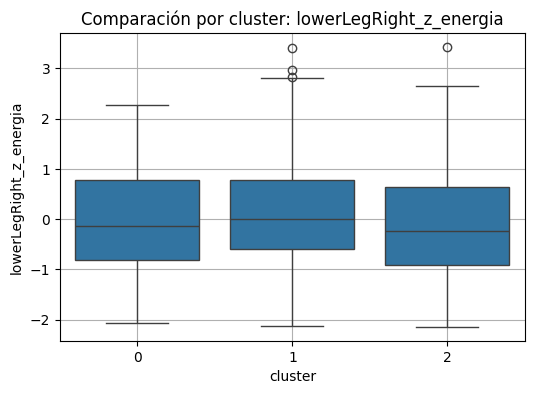

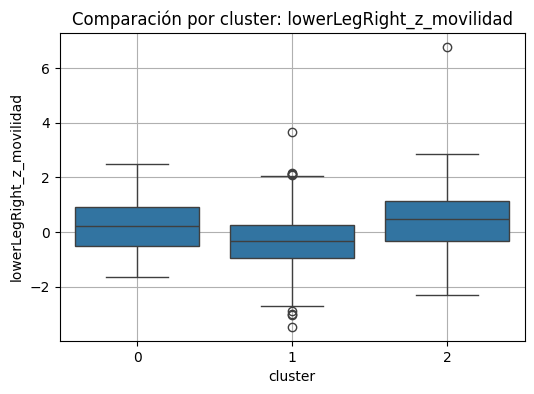

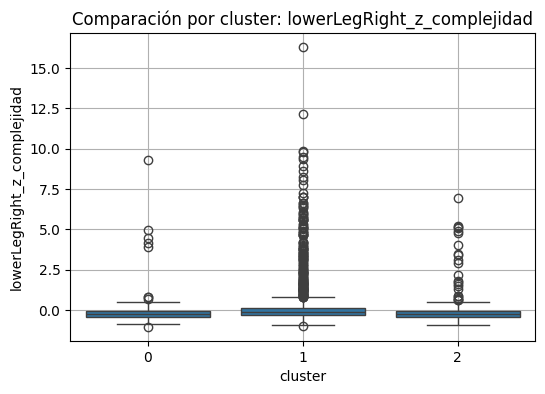

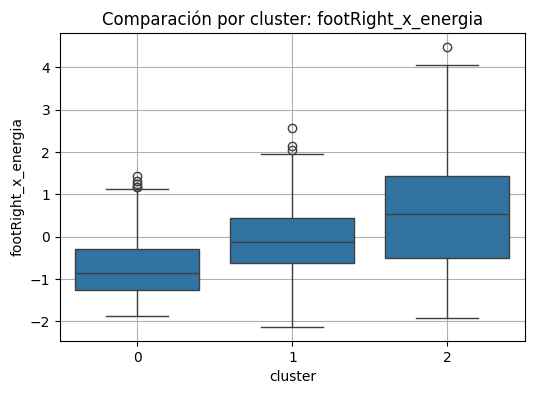

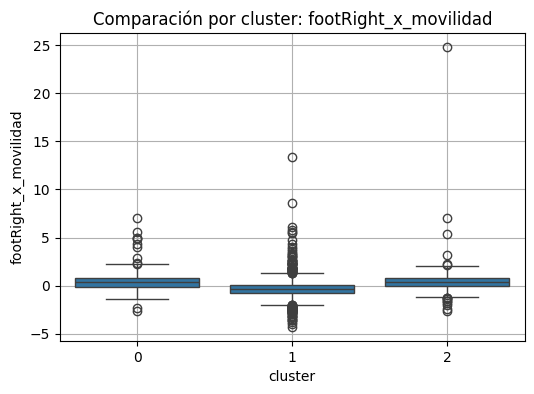

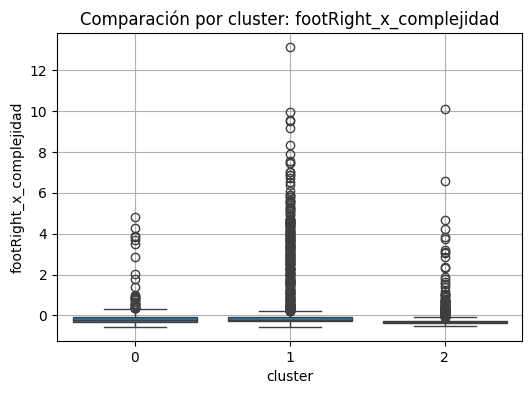

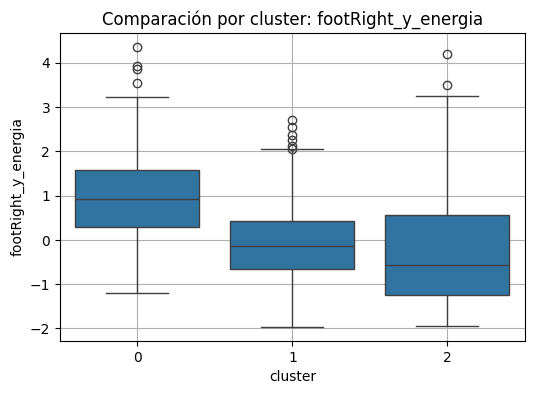

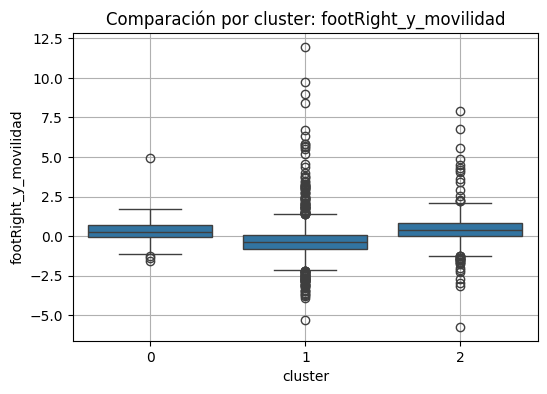

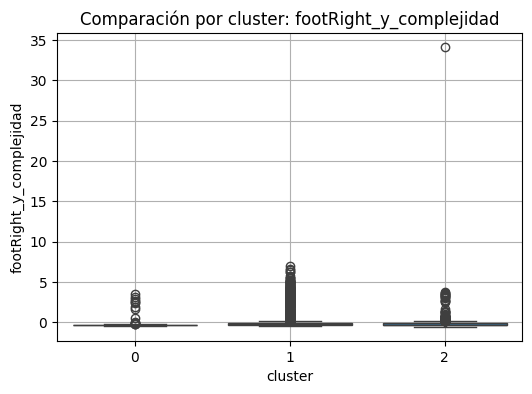

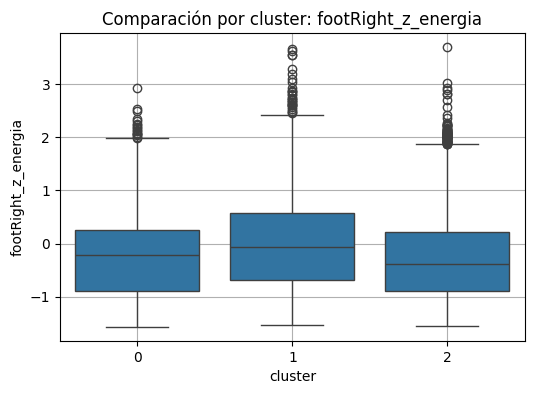

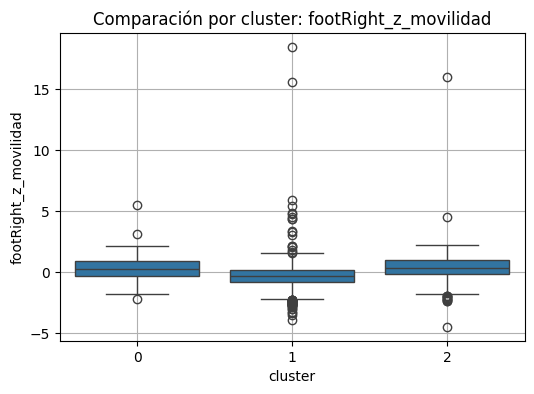

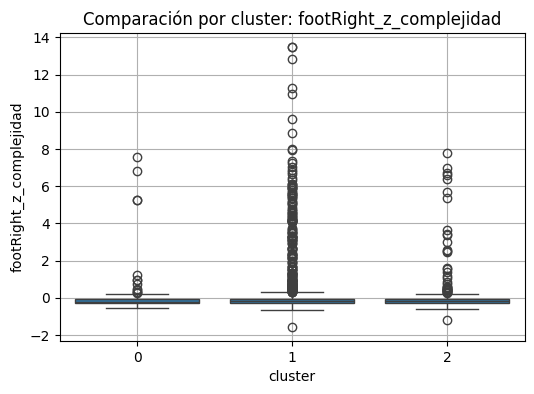

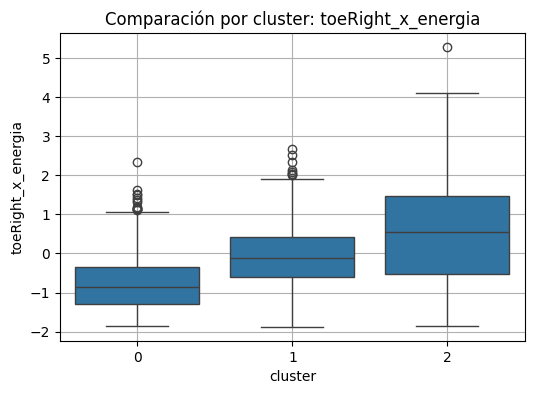

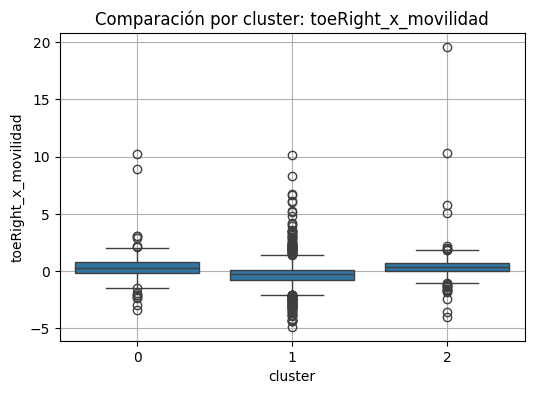

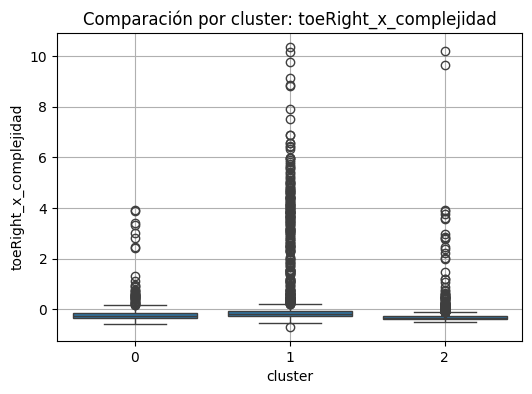

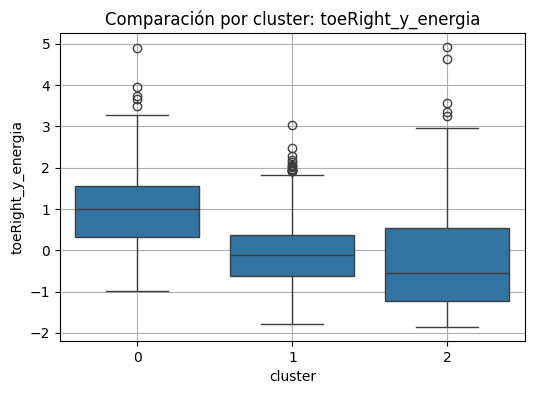

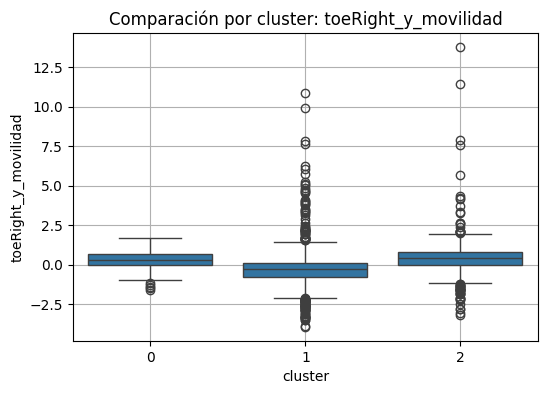

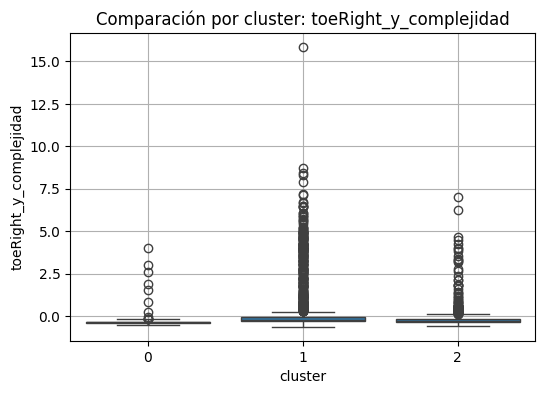

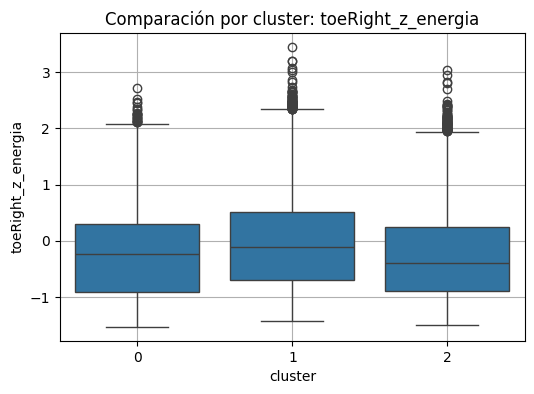

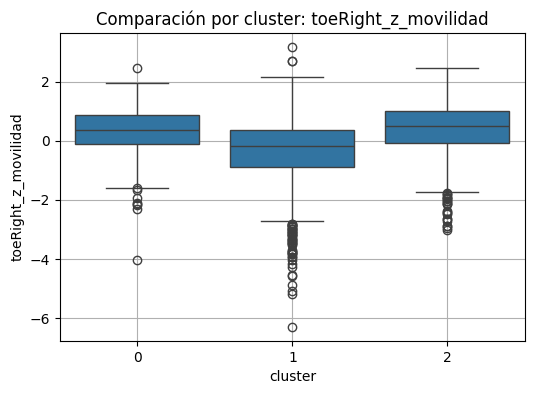

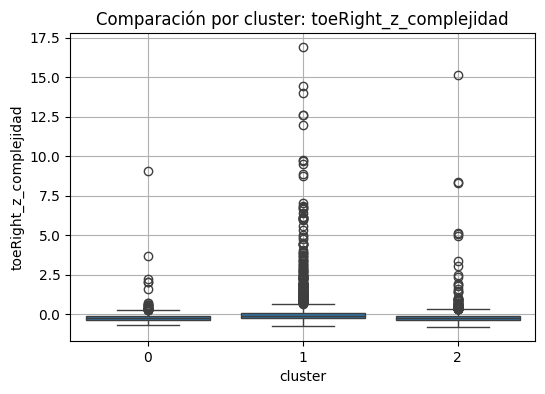

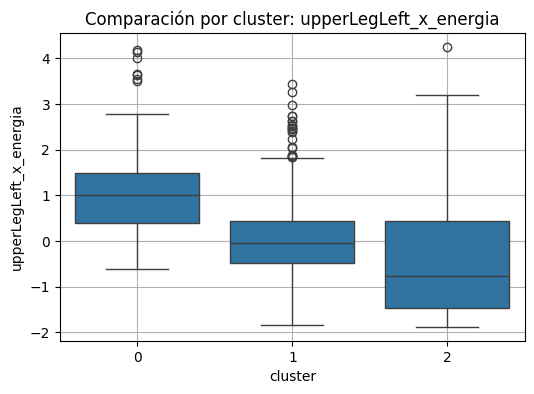

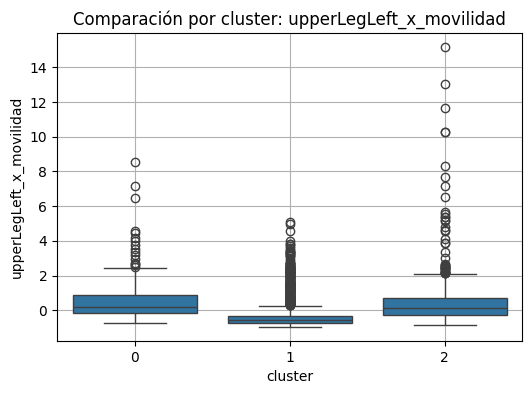

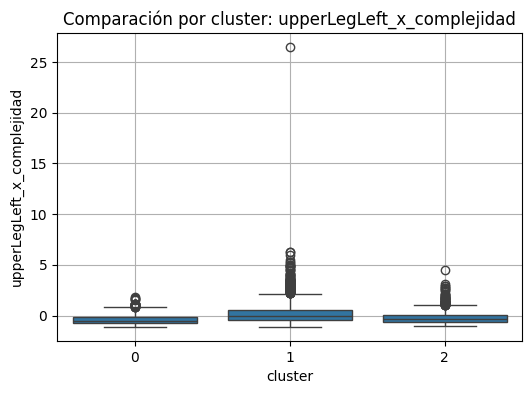

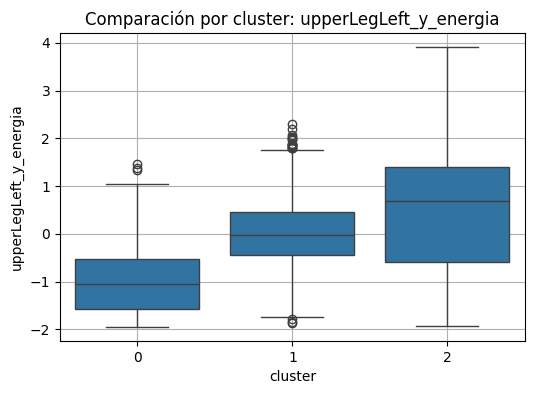

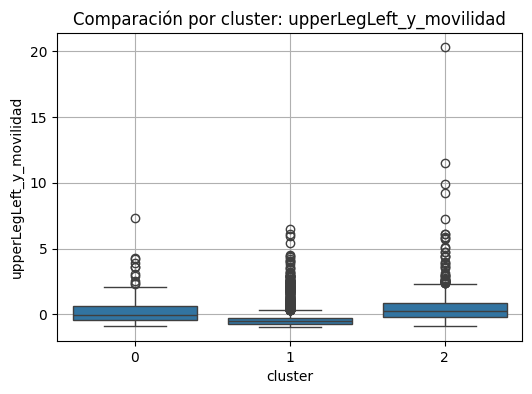

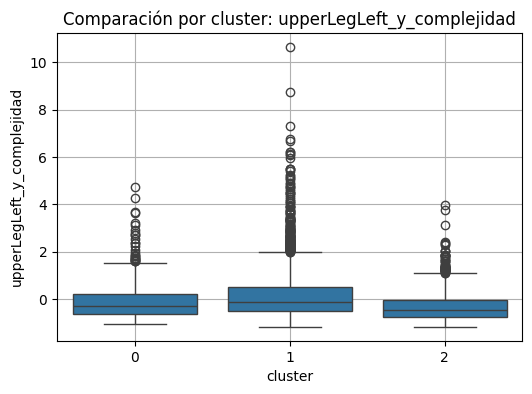

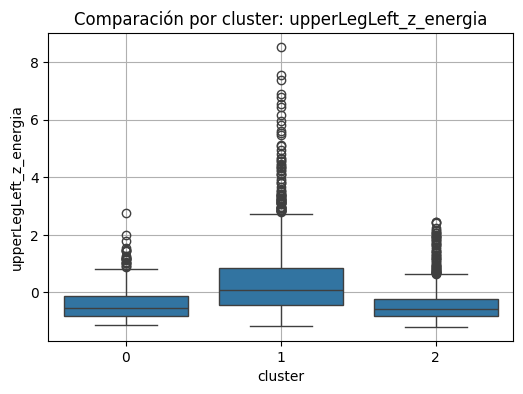

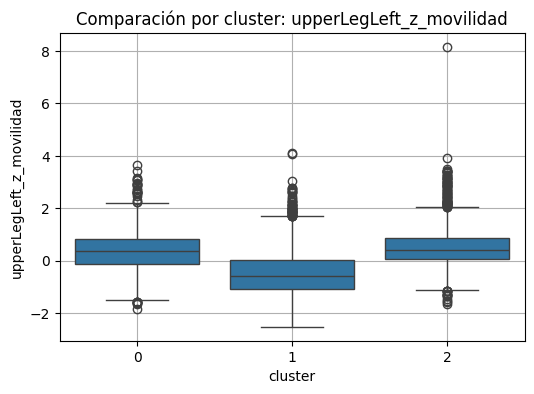

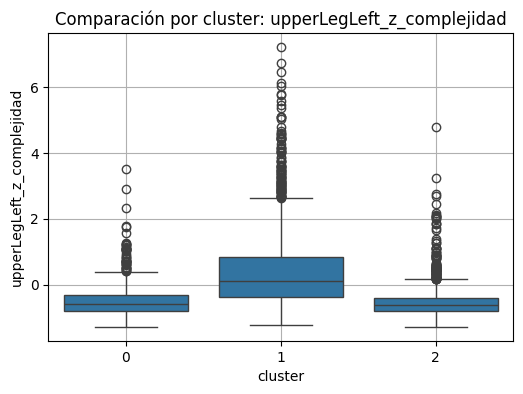

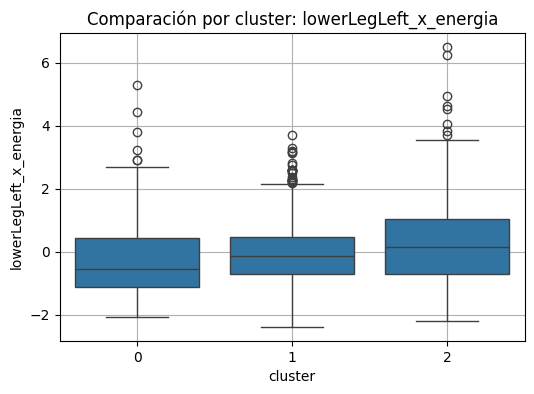

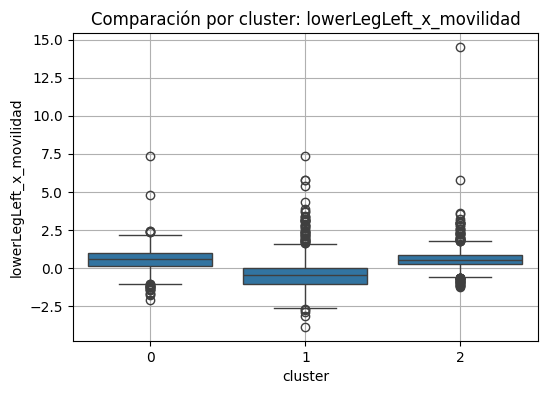

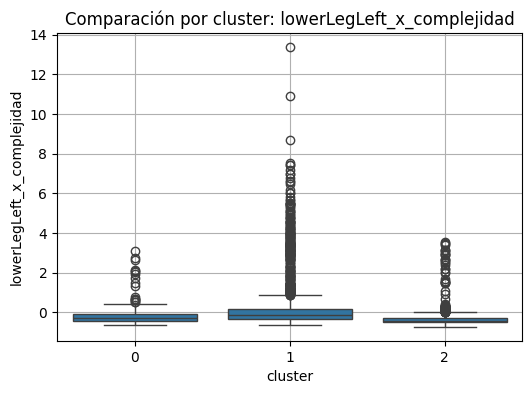

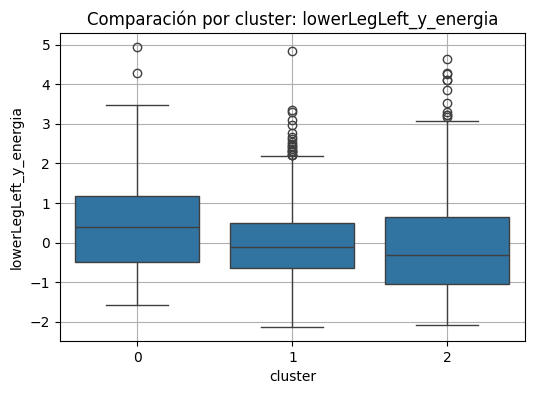

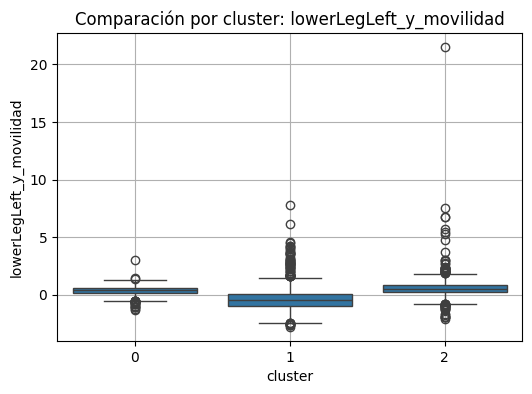

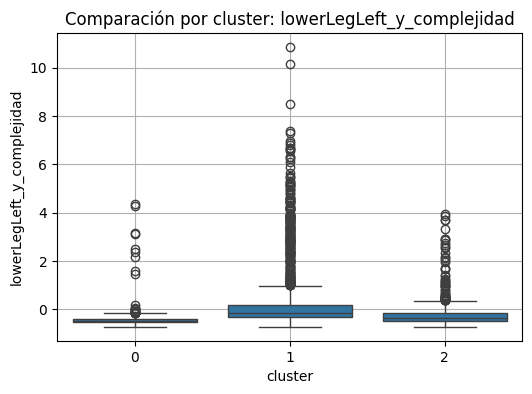

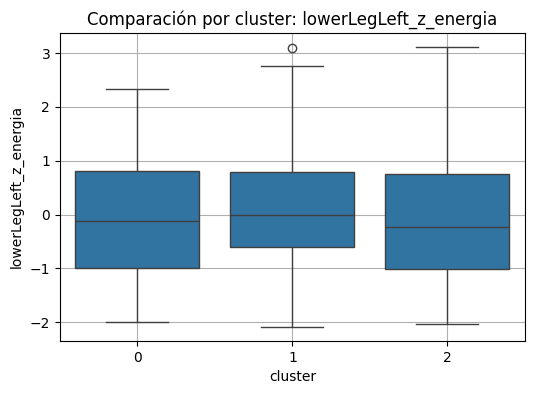

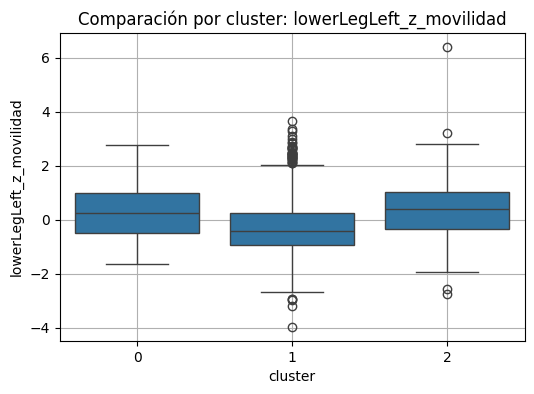

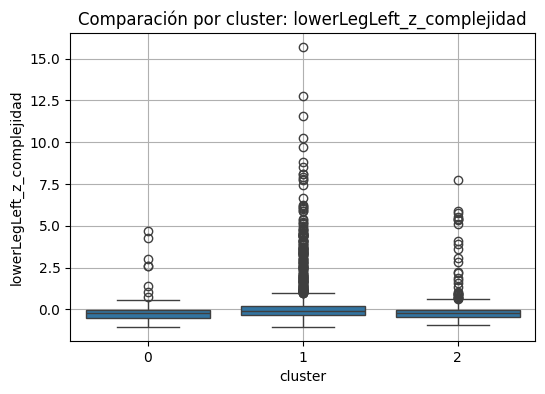

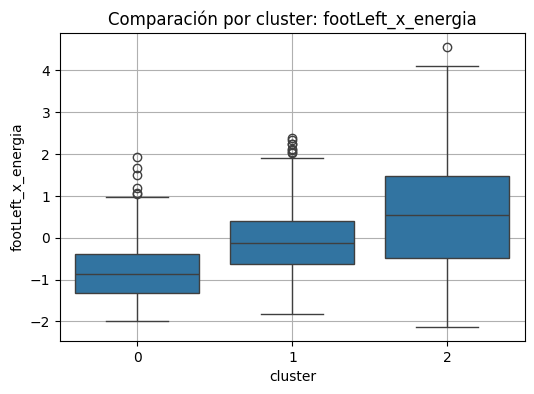

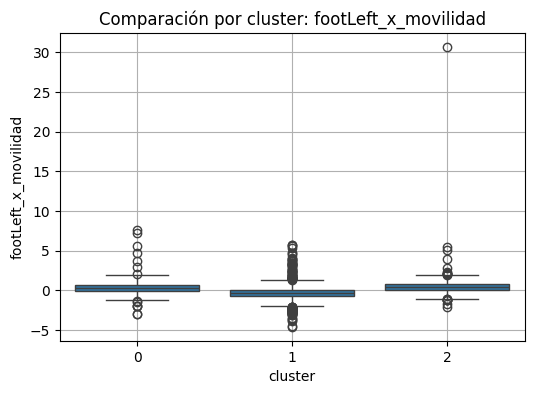

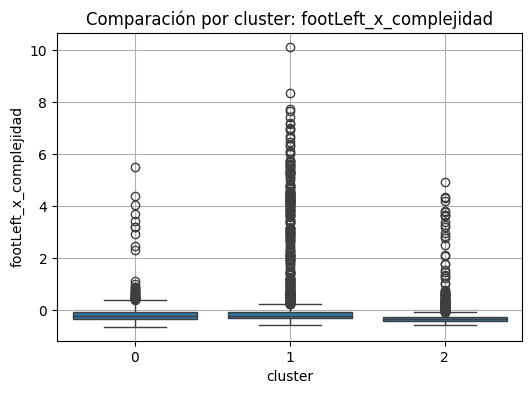

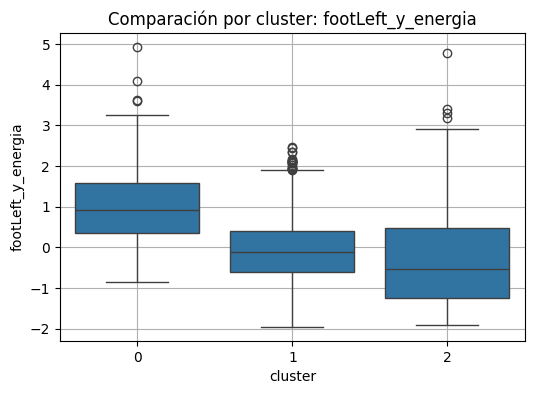

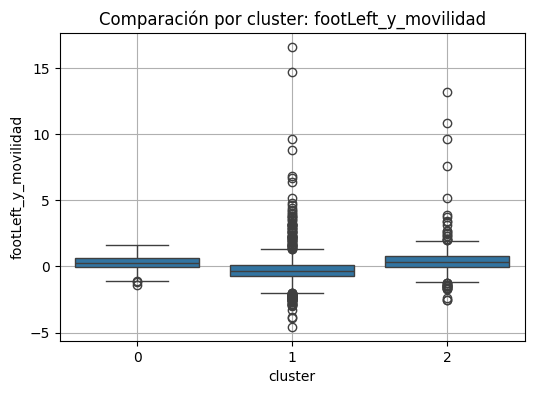

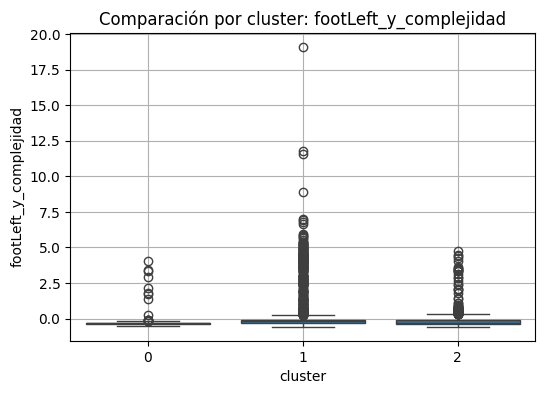

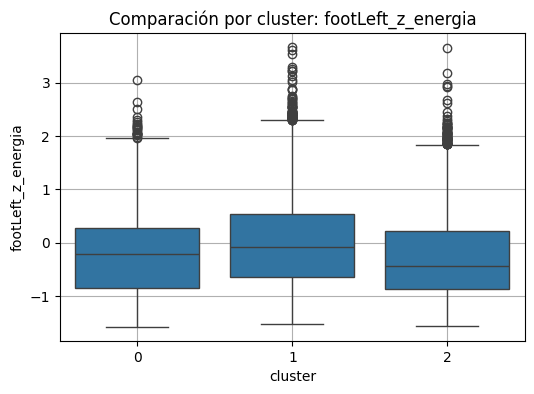

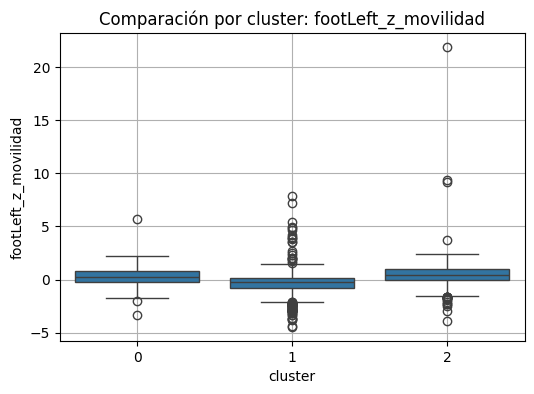

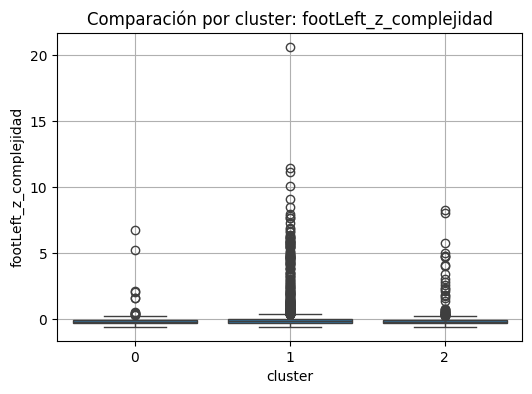

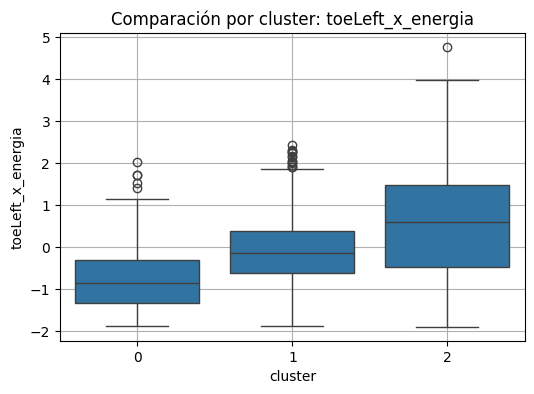

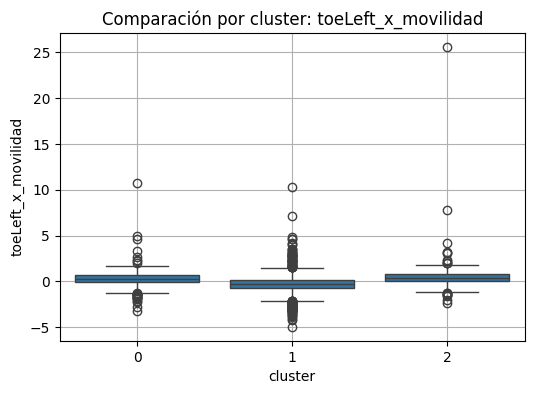

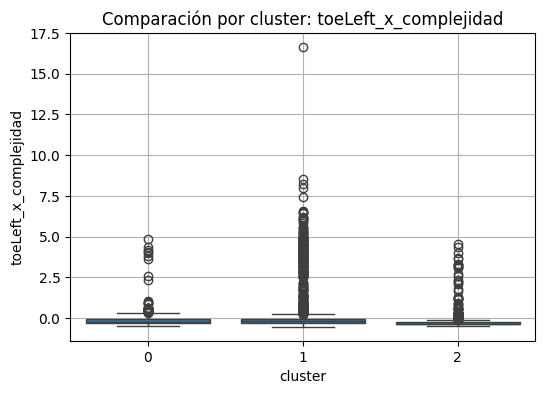

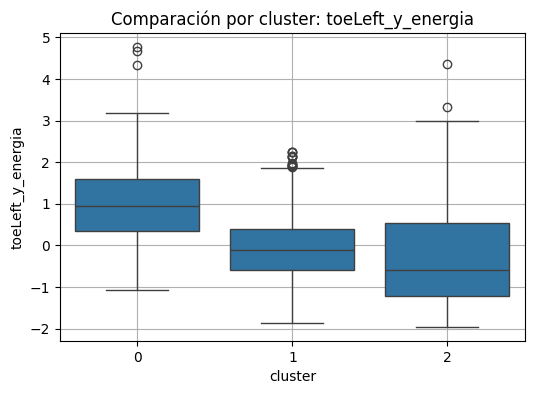

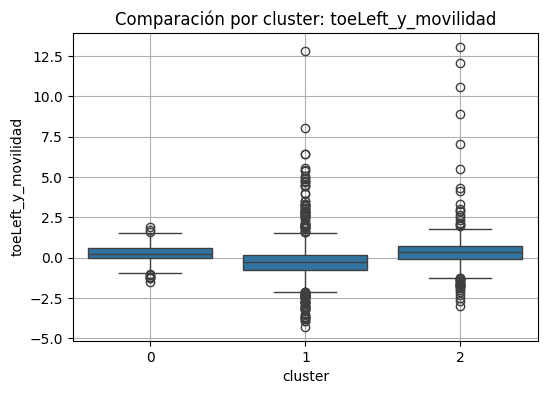

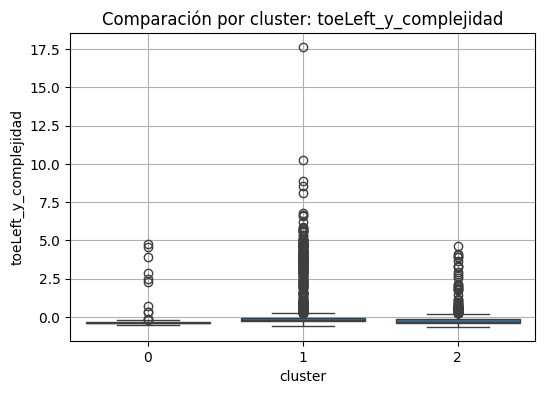

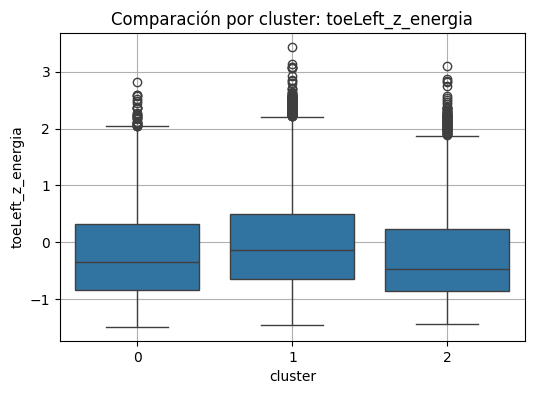

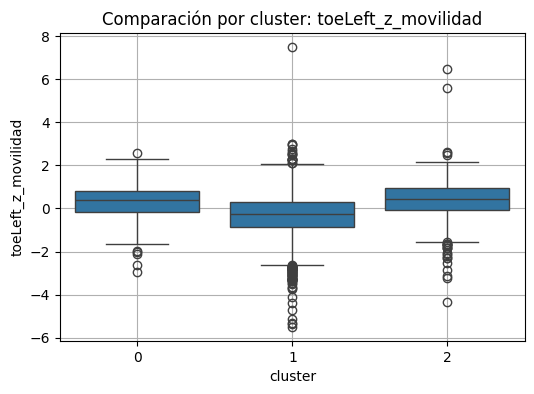

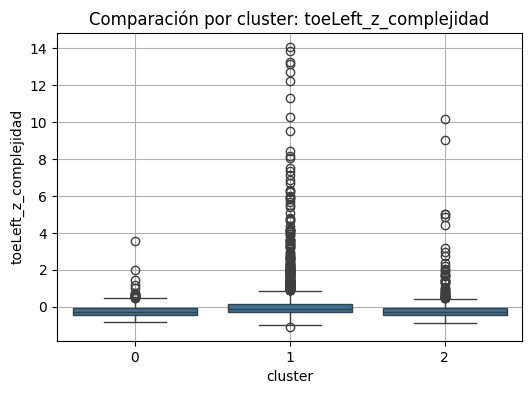

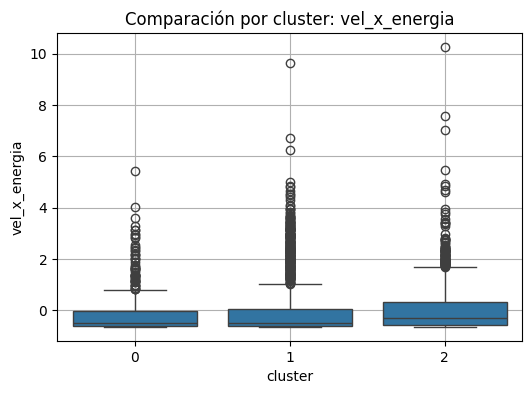

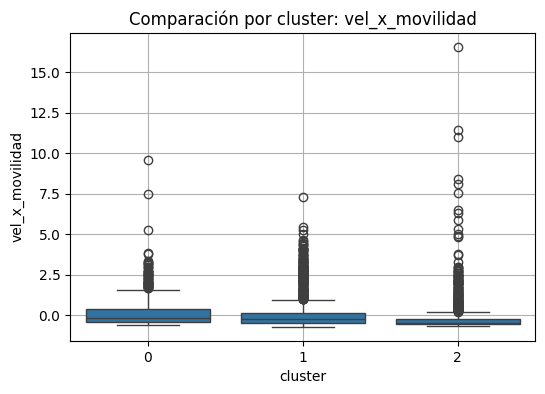

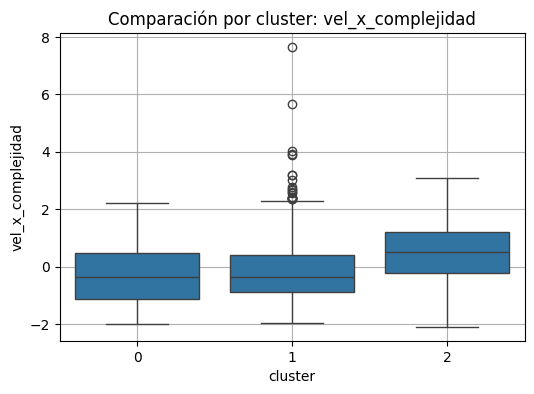

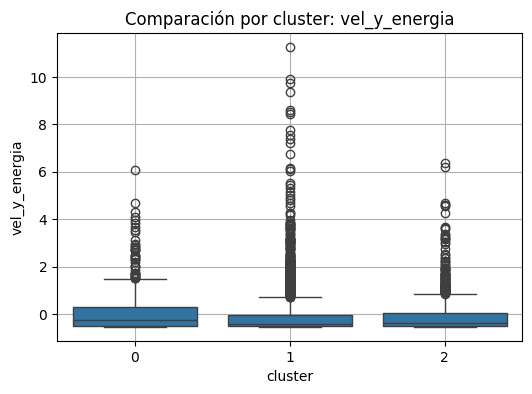

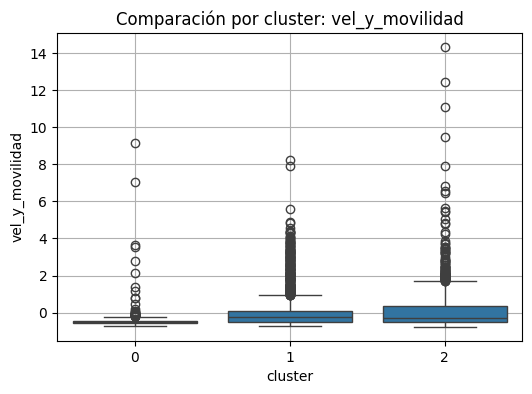

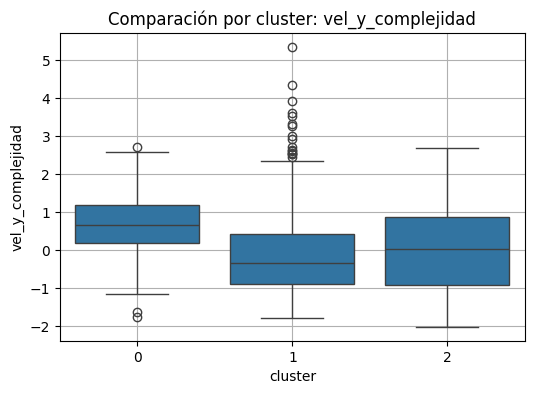

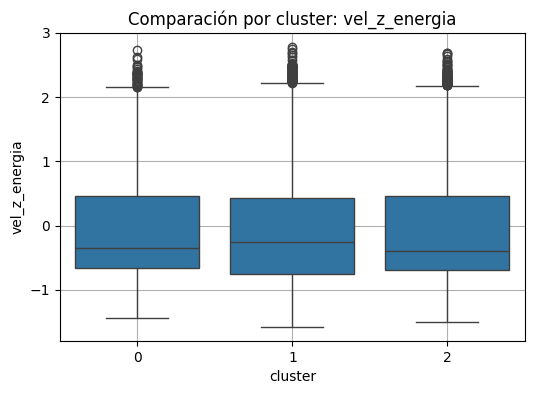

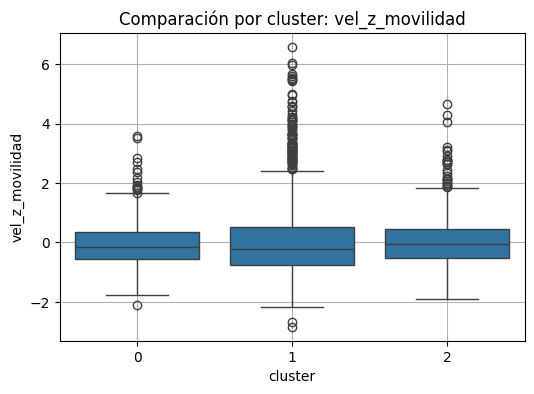

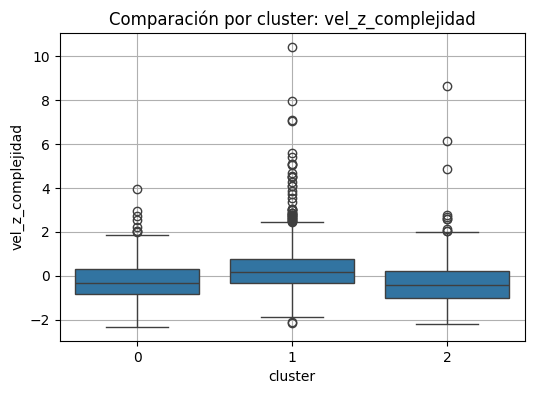

In [34]:
# Elegir características clave para visualizar (puedes ajustar esto)
caracteristicas_a_graficar = [c for c in columnas if 'energia' in c or 'movilidad' in c or 'complejidad' in c]

# Hacer boxplots para cada característica clave por cluster
for feature in caracteristicas_a_graficar:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cluster', y=feature, data=df_clusters)
    plt.title(f'Comparación por cluster: {feature}')
    plt.grid(True)
    plt.show()


## Observación en el boxplot	

Un cluster tiene mayor mediana en energía significa que ese grupo se mueve con más intensidad.

Un cluster tiene menor movilidad significa que los movimientos en ese grupo son más suaves o lentos.

Alta complejidad en un grupo significa que los movimientos son más irregulares o sofisticados.

Diferencias claras entre clusters significa que el clustering separó bien los tipos de movimiento.

## Análisis de movimiento

Vamos a analizar el antebrazo derecho en el eje x. Se puede analizar cualquier otra parte del cuerpo simplemente cambiando la columna de estudio.

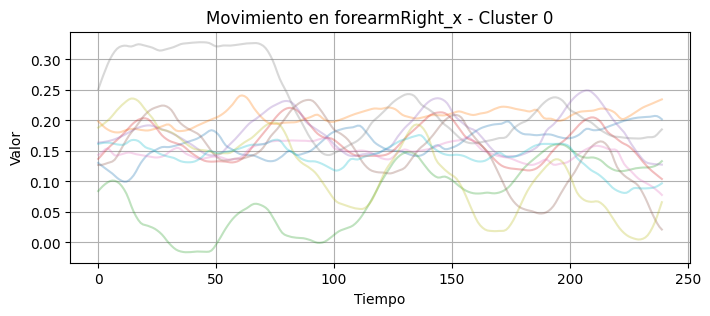

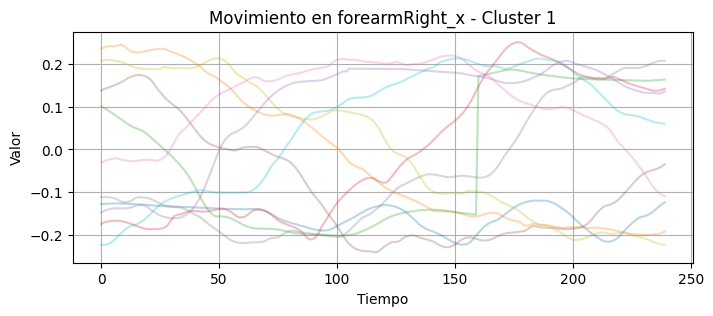

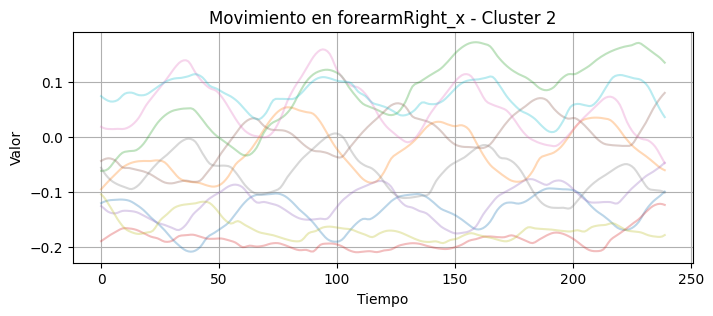

In [35]:
# Visualización del movimiento por cluster para una articulación y eje
articulacion = 'forearmRight_x'  # Ajusta según tus datos

for cl in np.unique(labels):
    ventanas_cluster = [a[i][articulacion].values for i in range(len(labels)) if labels[i] == cl]
    
    plt.figure(figsize=(8, 3))
    for signal in ventanas_cluster[:10]:  # Muestra hasta 10 ejemplos por cluster
        plt.plot(signal, alpha=0.3)
    plt.title(f'Movimiento en {articulacion} - Cluster {cl}')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.show()

Podemos observar como se han movido las articulaciones.
En el cluster 0 hay como un parón o disminución del movimiento a partir de más o menos el momento 100 de tiempo
En el cluster 1 podemos observar mucho caos, por lo que no podemos sacar mucho en claro, simplemente que son movimientos más aleatorios.
Sin embargo en el cluster 2 podemos observar picos y cierta repetición, por lo que se podría tratar de movimientos armónicos como el balanceo del brazo al caminar.